In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import random
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df_sp = pd.read_csv("../../data/spicata_clean_500.csv")
df_sp.head()

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\4074931185.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sp = pd.read_csv("../../data/spicata_clean_500.csv")


Unnamed: 0        id                       observed_on_string observed_on  \
0           0    156253                      1990-09-01 20:20:16  1990-09-01   
1           1  99704839  Fri May 20 1994 09:37:00 GMT-0400 (EDT)  1994-05-20   
2           2  99705133  Fri May 20 1994 09:37:00 GMT-0400 (EDT)  1994-05-20   
3           3    160735  Thu May 20 1994 15:27:35 GMT-0400 (EDT)  1994-05-20   
4           4  36335283  Wed Jul 28 1999 08:24:34 GMT-0400 (EDT)  1999-07-28   

            time_observed_at                   time_zone  user_id  \
0  1990-09-02 00:20:16+00:00  Eastern Time (US & Canada)      317   
1  1994-05-20 13:37:00+00:00  Eastern Time (US & Canada)      317   
2  1994-05-20 13:37:00+00:00  Eastern Time (US & Canada)      317   
3  1994-05-20 19:27:35+00:00  Eastern Time (US & Canada)      317   
4  1999-07-28 12:24:34+00:00  Eastern Time (US & Canada)      317   

                  created_at quality_grade  \
0  2012-12-03 02:52:30+00:00      research   
1  2021-10-29 13:45:37+00:00      research   
2  2021-10-29 13:49:59+00:00      research   
3  2012-12-11 20:23:37+00:00      research   
4  2019-12-04 01:50:03+00:00      research   

                                                 url  ...  \
0     http://www.inaturalist.org/observations/156253  ...   
1  https://www.inaturalist.org/observations/99704839  ...   
2  https://www.inaturalist.org/observations/99705133  ...   
3     http://www.inaturalist.org/observations/160735  ...   
4  https://www.inaturalist.org/observations/36335283  ...   

           species_guess          scientific_name            common_name  \
0            Cururu Toad        Rhinella diptycha            Cururu Toad   
1   Brown-headed Cowbird           Molothrus ater   Brown-headed Cowbird   
2      Northern Cardinal    Cardinalis cardinalis      Northern Cardinal   
3   Brown-headed Cowbird           Molothrus ater   Brown-headed Cowbird   
4  American Red Squirrel  Tamiasciurus hudsonicus  American Red Squirrel   

   taxon_kingdom_name  taxon_genus_name       taxon_species_name  \
0            Animalia          Rhinella        Rhinella diptycha   
1            Animalia         Molothrus           Molothrus ater   
2            Animalia        Cardinalis    Cardinalis cardinalis   
3            Animalia         Molothrus           Molothrus ater   
4            Animalia      Tamiasciurus  Tamiasciurus hudsonicus   

   geoprivacy_obscured  taxon_geoprivacy_obscured   minute_diff      km_diff  
0                    0                          0 -1.000000e-03    -0.001000  
1                    0                          0  1.953437e+06  7492.228775  
2                    0                          0  0.000000e+00     0.000000  
3                    0                          0  3.505833e+02     0.472500  
4                    0                          0  2.728377e+06    56.747939  

[5 rows x 30 columns]

In [3]:
# drop repeat index column
df_sp.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
# convert time objects to UTC datetimes
df_sp["time_observed_at"] = pd.to_datetime(df_sp["time_observed_at"], utc = True)
df_sp["created_at"] = pd.to_datetime(df_sp["created_at"], utc = True)

In [5]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050151 entries, 0 to 1050150
Data columns (total 29 columns):
 #   Column                            Non-Null Count    Dtype              
---  ------                            --------------    -----              
 0   id                                1050151 non-null  int64              
 1   observed_on_string                1050151 non-null  object             
 2   observed_on                       1050151 non-null  object             
 3   time_observed_at                  1050151 non-null  datetime64[ns, UTC]
 4   time_zone                         1050151 non-null  object             
 5   user_id                           1050151 non-null  int64              
 6   created_at                        1050151 non-null  datetime64[ns, UTC]
 7   quality_grade                     1050151 non-null  object             
 8   url                               1050151 non-null  object             
 9   image_url                         1

## Columns for Analyzing Datetimes

Datetimes don't work for models and many graphs. There are boundless ways to engineer the datetime for EDA and later modeling. For now, I am choosing two options:
1) Continuous: "time passed since" -- I am choosing the earliest time that occurs in the dataset (minimum value of "time_observed_at", setting it to zero and measuring the other times in minutes since that earliest time
2) Discrete values: Breaking the "time_observed_at" and "created_at" dates into a column for each of its discrete integer parts: Year, Month, Day, Hour (leaving out minutes, especially because I already have a column engineered from the original EDA that measures each observation for a user in minutes since their last observation)

### Continuous time columns -- "minutes since"

In [6]:
# Creates a column ("obs_time_conv_(minutes)") that measures all observation times in minutes 
#that have passed since first observation of dataset

min_time = df_sp["time_observed_at"].min() # finds first time_observed for dataset
time_since = df_sp["time_observed_at"] - min_time #calcs diff between time_observed for row and first time
time_obs_conv = round((time_since.dt.total_seconds()) / 60 , 2) # converts diff to minutes
df_sp.loc[:, "obs_time_conv_(minutes)"] = time_obs_conv # stores values in a new column

df_sp.sample(3) #sanity check


id         observed_on_string observed_on  \
521359  133159991  2022-08-31 15:17:45-05:00  2022-08-31   
19949      956596        2014-10-12 20:20:41  2014-10-12   
566805   75491488        2021-04-27 14:23:19  2021-04-27   

                time_observed_at                   time_zone  user_id  \
521359 2022-08-31 20:17:45+00:00  Central Time (US & Canada)   436529   
19949  2014-10-13 03:20:41+00:00  Pacific Time (US & Canada)      477   
566805 2021-04-27 21:23:19+00:00  Pacific Time (US & Canada)   538744   

                      created_at quality_grade  \
521359 2022-09-01 02:17:47+00:00      research   
19949  2014-10-13 06:04:08+00:00      needs_id   
566805 2021-04-28 00:19:43+00:00      research   

                                                      url  \
521359  https://www.inaturalist.org/observations/13315...   
19949      http://www.inaturalist.org/observations/956596   
566805  https://www.inaturalist.org/observations/75491488   

                                                image_url  ...  \
521359  https://inaturalist-open-data.s3.amazonaws.com...  ...   
19949   https://inaturalist-open-data.s3.amazonaws.com...  ...   
566805  https://inaturalist-open-data.s3.amazonaws.com...  ...   

              scientific_name         common_name  taxon_kingdom_name  \
521359        Verbena hastata        blue vervain             Plantae   
19949                  Agonum          not stated            Animalia   
566805  Clintonia andrewsiana  Andrews' Clintonia             Plantae   

        taxon_genus_name     taxon_species_name  geoprivacy_obscured  \
521359           Verbena        Verbena hastata                    0   
19949             Agonum             not stated                    0   
566805         Clintonia  Clintonia andrewsiana                    0   

        taxon_geoprivacy_obscured  minute_diff   km_diff  \
521359                          0    32.416667  0.197836   
19949                           0     0.216667  0.000000   
566805                          0    97.900000  0.027662   

       obs_time_conv_(minutes)  
521359             41051359.75  
19949              36904582.68  
566805             40344385.32  

[3 rows x 30 columns]

In [7]:
# Creates a column ("created_at_conv_(minutes)") that measures all "created_at" times in minutes 
# that have passed since first observation of dataset

# uses "min_time" from above--all still measured from first observation time, otherwise same code 
time_since = df_sp["created_at"] - min_time 
created_at_conv = round((time_since.dt.total_seconds()) / 60 , 2) 
df_sp.loc[:, "created_at_conv_(minutes)"] = created_at_conv
df_sp.sample(3)

id          observed_on_string observed_on  \
279731   64131600      2020/11/03 2:56 PM CST  2020-11-03   
922956   66053205  2020-12-02 11:58:43 AM MST  2020-12-02   
758599  173868027         2023-07-19 19:08:44  2023-07-19   

                time_observed_at                    time_zone  user_id  \
279731 2020-11-03 20:56:00+00:00   Central Time (US & Canada)   183583   
922956 2020-12-02 18:58:43+00:00  Mountain Time (US & Canada)  2850982   
758599 2023-07-20 00:08:44+00:00   Central Time (US & Canada)   953893   

                      created_at quality_grade  \
279731 2020-11-03 21:10:57+00:00      research   
922956 2020-12-03 18:40:43+00:00      research   
758599 2023-07-20 01:18:48+00:00      research   

                                                      url  \
279731  https://www.inaturalist.org/observations/64131600   
922956  https://www.inaturalist.org/observations/66053205   
758599  https://www.inaturalist.org/observations/17386...   

                                                image_url  ...  \
279731  https://inaturalist-open-data.s3.amazonaws.com...  ...   
922956  https://inaturalist-open-data.s3.amazonaws.com...  ...   
758599  https://inaturalist-open-data.s3.amazonaws.com...  ...   

            common_name  taxon_kingdom_name  taxon_genus_name  \
279731     Painted Lady            Animalia           Vanessa   
922956  Arizona madrone             Plantae           Arbutus   
758599   Chinese Tallow             Plantae          Triadica   

        taxon_species_name  geoprivacy_obscured  taxon_geoprivacy_obscured  \
279731      Vanessa cardui                    0                          0   
922956   Arbutus arizonica                    0                          0   
758599   Triadica sebifera                    0                          0   

        minute_diff   km_diff  obs_time_conv_(minutes)  \
279731    68.683333  0.236462              40092358.00   
922956     2.533333  0.106094              40134000.72   
758599    68.633333  4.176877              41515270.73   

       created_at_conv_(minutes)  
279731               40092372.95  
922956               40135422.72  
758599               41515340.80  

[3 rows x 31 columns]

### Discrete time columns -- Year, Month, Day and Hour

In [8]:
# using this method because it ran the fastest and didn't throw warnings 
# whereas other ways of storing these directly back int df_sp did

# creating empty dataframe to store converted columns
discrete_time_df = pd.DataFrame()

# creating discrete columns from observation times
discrete_time_df['obs_year'] = df_sp['time_observed_at'].dt.year
discrete_time_df['obs_month'] = df_sp['time_observed_at'].dt.month
discrete_time_df['obs_day'] = df_sp['time_observed_at'].dt.day
discrete_time_df['obs_hour'] = df_sp['time_observed_at'].dt.hour

# creating discrete columns from inat posting times
discrete_time_df['created_year'] = df_sp['created_at'].dt.year
discrete_time_df['created_month'] = df_sp['created_at'].dt.month
discrete_time_df['created_day'] = df_sp['created_at'].dt.day
discrete_time_df['created_hour'] = df_sp['created_at'].dt.hour

In [9]:
 df_sp = pd.concat([df_sp, discrete_time_df], axis = 1)

In [10]:
df_sp.sample(3)

id                       observed_on_string observed_on  \
50426     8316197                2017-10-06 2:28:11 PM CDT  2017-10-06   
905692  106457177  Wed Feb 09 2022 09:13:53 GMT-0500 (EST)  2022-02-09   
774685  133236958                2022-08-27 09:53:15-05:00  2022-08-27   

                time_observed_at                   time_zone  user_id  \
50426  2017-10-06 19:28:11+00:00  Central Time (US & Canada)     8882   
905692 2022-02-09 14:13:53+00:00  Eastern Time (US & Canada)  2588524   
774685 2022-08-27 14:53:15+00:00  Central Time (US & Canada)  1174034   

                      created_at quality_grade  \
50426  2017-10-08 21:19:43+00:00      needs_id   
905692 2022-02-09 21:41:52+00:00      research   
774685 2022-09-01 18:13:19+00:00      research   

                                                      url  \
50426    https://www.inaturalist.org/observations/8316197   
905692  https://www.inaturalist.org/observations/10645...   
774685  https://www.inaturalist.org/observations/13323...   

                                                image_url  ...  \
50426   https://inaturalist-open-data.s3.amazonaws.com...  ...   
905692  https://inaturalist-open-data.s3.amazonaws.com...  ...   
774685  https://inaturalist-open-data.s3.amazonaws.com...  ...   

       obs_time_conv_(minutes)  created_at_conv_(minutes)  obs_year  \
50426              38473710.18                38476701.72      2017   
905692             40758675.88                40759123.87      2022   
774685             41045275.25                41052675.32      2022   

        obs_month  obs_day  obs_hour  created_year  created_month  \
50426          10        6        19          2017             10   
905692          2        9        14          2022              2   
774685          8       27        14          2022              9   

        created_day created_hour  
50426             8           21  
905692            9           21  
774685            1           18  

[3 rows x 39 columns]

# Random User 923056

To explore how finding a user's "hikes" works, I picked a user at random using the commented out code and then did an exploratory analysis of that user's data and how one might go about modeling the user's hikes. 
 


In [11]:
# Code for choosing random user
#users = df_sp["user_id"].unique()
#np.random.choice(users)

In [12]:
random_user = 923056
rand_user_df = df_sp[df_sp["user_id"] == random_user]
rand_user_df.reset_index(inplace = True, drop = True)
rand_user_df.sample(3)

id                       observed_on_string observed_on  \
179   48903844  Sun Jun 07 2020 19:38:38 GMT-0600 (MDT)  2020-06-07   
118   30954343  Fri Aug 16 2019 15:53:26 GMT-0400 (EDT)  2019-08-16   
214  168666703                2023-06-21 09:24:04-06:00  2023-06-21   

             time_observed_at                    time_zone  user_id  \
179 2020-06-08 01:38:38+00:00  Mountain Time (US & Canada)   923056   
118 2019-08-16 19:53:26+00:00   Eastern Time (US & Canada)   923056   
214 2023-06-21 15:24:04+00:00  Mountain Time (US & Canada)   923056   

                   created_at quality_grade  \
179 2020-06-08 13:03:48+00:00      needs_id   
118 2019-08-16 21:24:43+00:00      needs_id   
214 2023-06-21 15:25:25+00:00      needs_id   

                                                   url  \
179  https://www.inaturalist.org/observations/48903844   
118  https://www.inaturalist.org/observations/30954343   
214  https://www.inaturalist.org/observations/16866...   

                                             image_url  ...  \
179  https://static.inaturalist.org/photos/77616825...  ...   
118  https://static.inaturalist.org/photos/48396657...  ...   
214  https://static.inaturalist.org/photos/29274944...  ...   

    obs_time_conv_(minutes)  created_at_conv_(minutes)  obs_year  obs_month  \
179             39878080.63                39878765.80      2020          6   
118             39451495.43                39451586.72      2019          8   
214             41474426.07                41474427.42      2023          6   

     obs_day  obs_hour  created_year  created_month  created_day created_hour  
179        8         1          2020              6            8           13  
118       16        19          2019              8           16           21  
214       21        15          2023              6           21           15  

[3 rows x 39 columns]

In [13]:
rand_user_df.head()

id                       observed_on_string observed_on  \
0  26643807  Tue Apr 10 2018 16:18:13 GMT-0400 (EDT)  2018-04-10   
1  11769873  Sun Apr 29 2018 14:05:21 GMT-0400 (EDT)  2018-04-29   
2  11784631  Sun Apr 29 2018 16:09:45 GMT-0400 (EDT)  2018-04-29   
3  26643745  Thu May 10 2018 21:35:19 GMT-0400 (EDT)  2018-05-10   
4  26643675  Sun May 20 2018 16:03:39 GMT-0400 (EDT)  2018-05-20   

           time_observed_at                   time_zone  user_id  \
0 2018-04-10 20:18:13+00:00  Eastern Time (US & Canada)   923056   
1 2018-04-29 18:05:21+00:00  Eastern Time (US & Canada)   923056   
2 2018-04-29 20:09:45+00:00  Eastern Time (US & Canada)   923056   
3 2018-05-11 01:35:19+00:00  Eastern Time (US & Canada)   923056   
4 2018-05-20 20:03:39+00:00  Eastern Time (US & Canada)   923056   

                 created_at quality_grade  \
0 2019-06-09 00:25:55+00:00      research   
1 2018-04-29 18:08:16+00:00        casual   
2 2018-04-29 20:10:42+00:00      needs_id   
3 2019-06-09 00:25:08+00:00      research   
4 2019-06-09 00:24:27+00:00      research   

                                                 url  \
0  https://www.inaturalist.org/observations/26643807   
1  https://www.inaturalist.org/observations/11769873   
2  https://www.inaturalist.org/observations/11784631   
3  https://www.inaturalist.org/observations/26643745   
4  https://www.inaturalist.org/observations/26643675   

                                           image_url  ...  \
0  https://static.inaturalist.org/photos/41383609...  ...   
1  https://static.inaturalist.org/photos/16832346...  ...   
2  https://static.inaturalist.org/photos/16855097...  ...   
3  https://static.inaturalist.org/photos/41383540...  ...   
4  https://static.inaturalist.org/photos/41383503...  ...   

  obs_time_conv_(minutes)  created_at_conv_(minutes)  obs_year  obs_month  \
0             38741600.22                39352407.92      2018          4   
1             38768827.35                38768830.27      2018          4   
2             38768951.75                38768952.70      2018          4   
3             38785117.32                39352407.13      2018          5   
4             38799185.65                39352406.45      2018          5   

   obs_day  obs_hour  created_year  created_month  created_day created_hour  
0       10        20          2019              6            9            0  
1       29        18          2018              4           29           18  
2       29        20          2018              4           29           20  
3       11         1          2019              6            9            0  
4       20        20          2019              6            9            0  

[5 rows x 39 columns]

## Bivariate EDA on Random_User

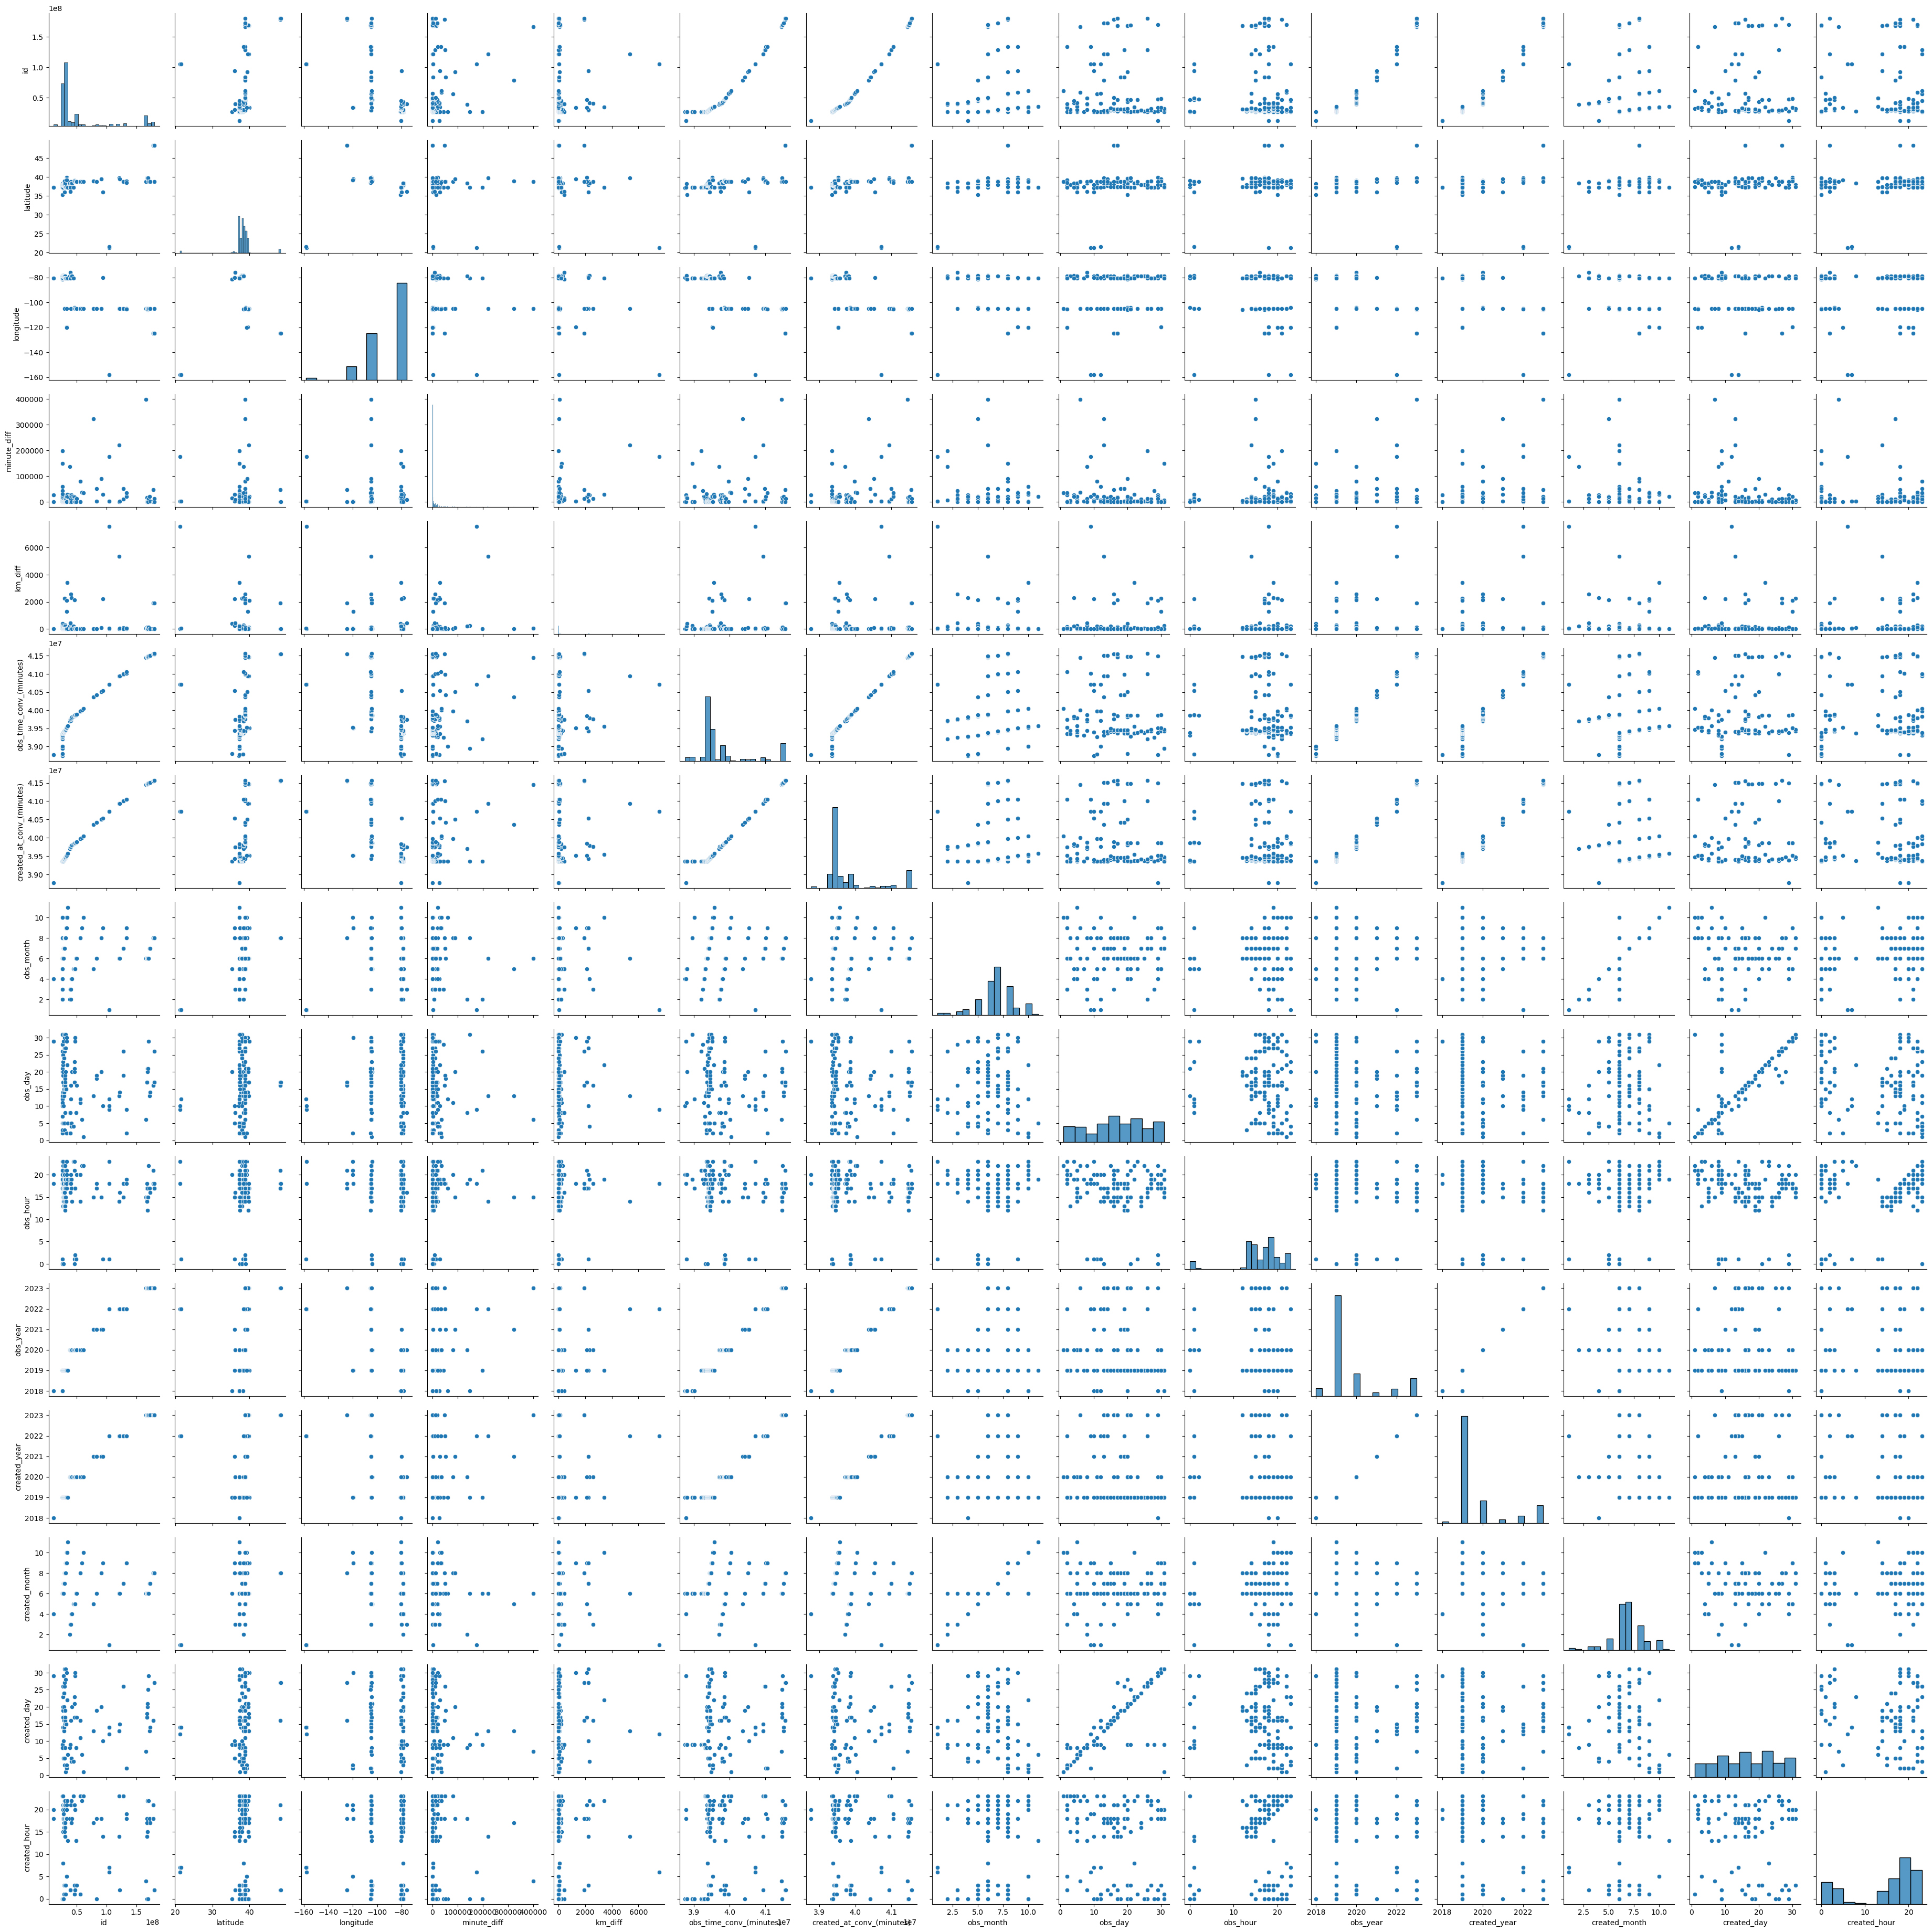

In [14]:
# choosing the columns I'm targeting for identifying geo/time clusters for "hikes"
pairplot_df = rand_user_df[['id', 'latitude',
       'longitude', 'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 'obs_month', 'obs_day', 'obs_hour', 'obs_year',
       'created_year', 'created_month', 'created_day', 'created_hour']]

sns.pairplot(pairplot_df)





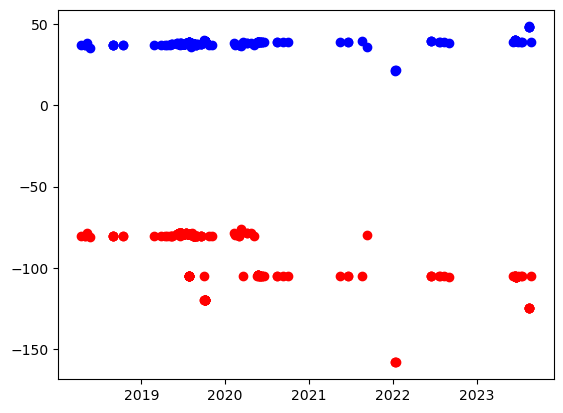

In [15]:
plt.figure()
plt.scatter(rand_user_df["time_observed_at"], rand_user_df["longitude"], c = 'red')
plt.scatter(rand_user_df["time_observed_at"], rand_user_df["latitude"], c = 'blue')
plt.show()

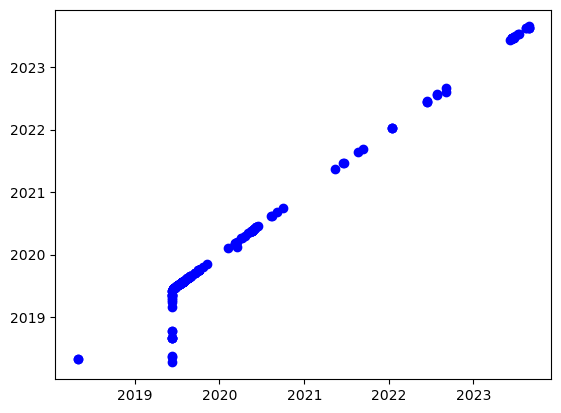

In [16]:
plt.figure()
plt.scatter(rand_user_df["created_at"], rand_user_df["time_observed_at"], c = 'blue')
plt.show()

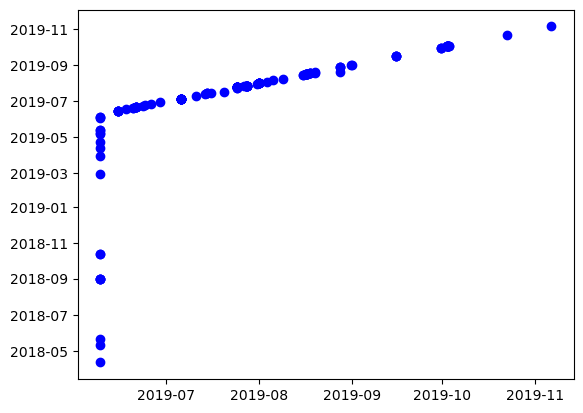

In [17]:
closer_look = rand_user_df[rand_user_df["created_at"].dt.strftime('%Y') == '2019']
plt.figure()
plt.scatter(closer_look["created_at"], closer_look["time_observed_at"], c = 'blue')
plt.show()

In [18]:
closer_look.head()

id                       observed_on_string observed_on  \
0  26643807  Tue Apr 10 2018 16:18:13 GMT-0400 (EDT)  2018-04-10   
3  26643745  Thu May 10 2018 21:35:19 GMT-0400 (EDT)  2018-05-10   
4  26643675  Sun May 20 2018 16:03:39 GMT-0400 (EDT)  2018-05-20   
5  26643587  Fri Aug 31 2018 15:36:32 GMT-0400 (EDT)  2018-08-31   
6  26643040  Fri Aug 31 2018 15:37:17 GMT-0400 (EDT)  2018-08-31   

           time_observed_at                   time_zone  user_id  \
0 2018-04-10 20:18:13+00:00  Eastern Time (US & Canada)   923056   
3 2018-05-11 01:35:19+00:00  Eastern Time (US & Canada)   923056   
4 2018-05-20 20:03:39+00:00  Eastern Time (US & Canada)   923056   
5 2018-08-31 19:36:32+00:00  Eastern Time (US & Canada)   923056   
6 2018-08-31 19:37:17+00:00  Eastern Time (US & Canada)   923056   

                 created_at quality_grade  \
0 2019-06-09 00:25:55+00:00      research   
3 2019-06-09 00:25:08+00:00      research   
4 2019-06-09 00:24:27+00:00      research   
5 2019-06-09 00:23:04+00:00      needs_id   
6 2019-06-09 00:12:17+00:00      research   

                                                 url  \
0  https://www.inaturalist.org/observations/26643807   
3  https://www.inaturalist.org/observations/26643745   
4  https://www.inaturalist.org/observations/26643675   
5  https://www.inaturalist.org/observations/26643587   
6  https://www.inaturalist.org/observations/26643040   

                                           image_url  ...  \
0  https://static.inaturalist.org/photos/41383609...  ...   
3  https://static.inaturalist.org/photos/41383540...  ...   
4  https://static.inaturalist.org/photos/41383503...  ...   
5  https://static.inaturalist.org/photos/41383396...  ...   
6  https://static.inaturalist.org/photos/41382442...  ...   

  obs_time_conv_(minutes)  created_at_conv_(minutes)  obs_year  obs_month  \
0             38741600.22                39352407.92      2018          4   
3             38785117.32                39352407.13      2018          5   
4             38799185.65                39352406.45      2018          5   
5             38947478.53                39352405.07      2018          8   
6             38947479.28                39352394.28      2018          8   

   obs_day  obs_hour  created_year  created_month  created_day created_hour  
0       10        20          2019              6            9            0  
3       11         1          2019              6            9            0  
4       20        20          2019              6            9            0  
5       31        19          2019              6            9            0  
6       31        19          2019              6            9            0  

[5 rows x 39 columns]

In [19]:
(rand_user_df["created_at"].dt.strftime('%D') == '06/09/19').sum()

13

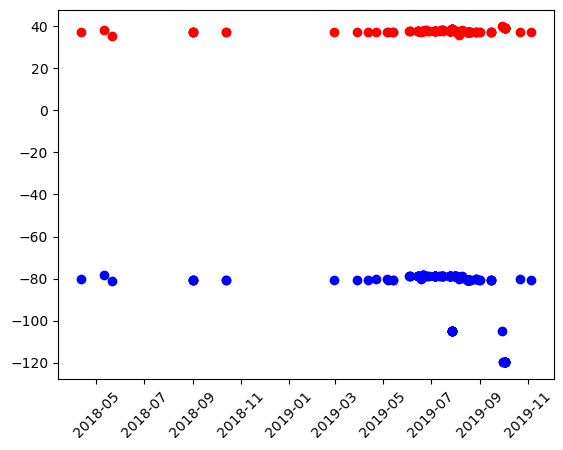

In [20]:
plt.figure()
plt.scatter(closer_look["time_observed_at"], closer_look["latitude"], c = 'red')
plt.scatter(closer_look["time_observed_at"], closer_look["longitude"], c = 'blue')
plt.xticks(rotation = 45)
plt.show()

# Modeling -- Initial Exploration

## What can I find by just grouping by date?

Before trying complicated algorithms, a simple data analytics approach might choose to groupby date of observation time to approximate a "hike". I'll create clusters using this technique first and then compare to what emerges when I use clustering models.

In [21]:
# Use the date of time_observated_at to group and count rows
# Look at top 20 values when sorted lowest to highest
potential_hikes = rand_user_df["time_observed_at"].dt.strftime('%D').value_counts().sort_values().tail(20)
potential_hikes

08/17/23     3
06/08/20     3
08/27/19     3
06/20/23     3
07/14/19     3
08/17/19     4
05/30/20     4
08/31/18     4
09/15/19     4
06/17/23     6
06/20/19     6
06/21/23     6
05/20/20     6
06/14/19     6
07/31/19     9
08/16/19    10
07/27/19    11
10/02/19    12
07/05/19    14
07/24/19    21
Name: time_observed_at, dtype: int64

If I use 5 as a minimum for grouping, there are 11 "groups" here that might represent single hikes. Or 5 groups if I choose 10 or more as a grouping standard. 

In [22]:
# making an array of the dates with at least as many observations as the min_samples specified

min_samples = 10 # using same terminology as DBSCAN
top_dates = potential_hikes[potential_hikes.values >= min_samples].index
top_dates

Index(['08/16/19', '07/27/19', '10/02/19', '07/05/19', '07/24/19'], dtype='object')

In [23]:
# creating dictionary that will assign an integer to each cluster

artificial_cluster = {}
i = 0
for day in top_dates:
    artificial_cluster[day] = i
    i += 1
artificial_cluster
    

{'08/16/19': 0, '07/27/19': 1, '10/02/19': 2, '07/05/19': 3, '07/24/19': 4}

In [24]:
# Adding a cluster column to the dataframe

for i in range(rand_user_df.shape[0]):
    # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
    if rand_user_df.loc[i, "time_observed_at"].strftime('%D') in top_dates:
        rand_user_df.loc[i, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[i, "time_observed_at"].strftime('%D')]
    # otherwise, the new column will be assigned a -1 (the way DBSCAN does for non clusters)
    else:
        rand_user_df.loc[i, "Artif_Cluster"] = -1
rand_user_df.sample(3)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2918866158.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df.loc[i, "Artif_Cluster"] = -1


id                       observed_on_string observed_on  \
215  169289634                2023-06-21 09:27:59-06:00  2023-06-21   
171   46917634  Fri May 22 2020 19:40:23 GMT-0600 (MDT)  2020-05-22   
154   40100039  Wed Feb 12 2020 13:58:35 GMT-0700 (MST)  2020-02-12   

             time_observed_at                    time_zone  user_id  \
215 2023-06-21 15:27:59+00:00  Mountain Time (US & Canada)   923056   
171 2020-05-23 01:40:23+00:00  Mountain Time (US & Canada)   923056   
154 2020-02-12 20:58:35+00:00  Mountain Time (US & Canada)   923056   

                   created_at quality_grade  \
215 2023-06-25 00:29:05+00:00      needs_id   
171 2020-05-23 01:51:12+00:00        casual   
154 2020-03-16 21:41:33+00:00      research   

                                                   url  \
215  https://www.inaturalist.org/observations/16928...   
171  https://www.inaturalist.org/observations/46917634   
154  https://www.inaturalist.org/observations/40100039   

                                             image_url  ...  \
215  https://static.inaturalist.org/photos/29348023...  ...   
171  https://static.inaturalist.org/photos/74408126...  ...   
154  https://static.inaturalist.org/photos/63689696...  ...   

    created_at_conv_(minutes)  obs_year  obs_month  obs_day  obs_hour  \
215               41479291.08      2023          6       21        15   
171               39855053.20      2020          5       23         1   
154               39758323.55      2020          2       12        20   

     created_year  created_month  created_day  created_hour Artif_Cluster  
215          2023              6           25             0          -1.0  
171          2020              5           23             1          -1.0  
154          2020              3           16            21          -1.0  

[3 rows x 40 columns]

In [25]:
# making this column an integer because for some reason its a float
rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\1816998298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)


In [26]:
# sanity check
(rand_user_df["Artif_Cluster"] != -1).sum()

68

In [27]:
potential_hikes[potential_hikes.values >= min_samples].sum()

68

# Comment this definition to explain it

In [28]:
def cluster_overview(col, df = rand_user_df, x = "time_observed_at", y_1 = "latitude", y_2 = "longitude"):
    
    '''
    something here
    '''
    
    # defining a set of colors to use for graphing clusters --can add more here if clustering ends up having more labels
    class_colors = ['#A9A9A9', '#FF000D', '#BC13FE', '#FF7124', '#41FDFE', '#FF028D', '#21FC0D', '#FFF700', '#0165FC', '#000000']
    
    plt.figure(figsize=(19, 4))

    labels = np.sort(df[col].unique()) 
    # I've only specified 10 colors for labels, so if there are more, 
    # I'm visualizing the top 10 largest (by count) clusters 
    if len(labels) > 10:
        labels = np.sort(df[col].value_counts().head(10).index)

    # makes a separate scatter for each cluster label, which allows color and label to be assigned separately
    c = 0 # for assigning a color
    for i in labels: 
        subset = df[df[col] == i]
        # Create a scatter plot for each subset with the corresponding color and label--one for lat and one for lon
        plt.scatter(subset[x], subset[y_1], c=class_colors[c], label= i, alpha = 0.7)
        plt.scatter(subset[x], subset[y_2], c=class_colors[c], alpha = 0.7)
        plt.xlabel(x)
        plt.ylabel(f'{y_1} \nand {y_2}')
        plt.title("Clusters")
        c += 1


    plt.legend()
    plt.show()

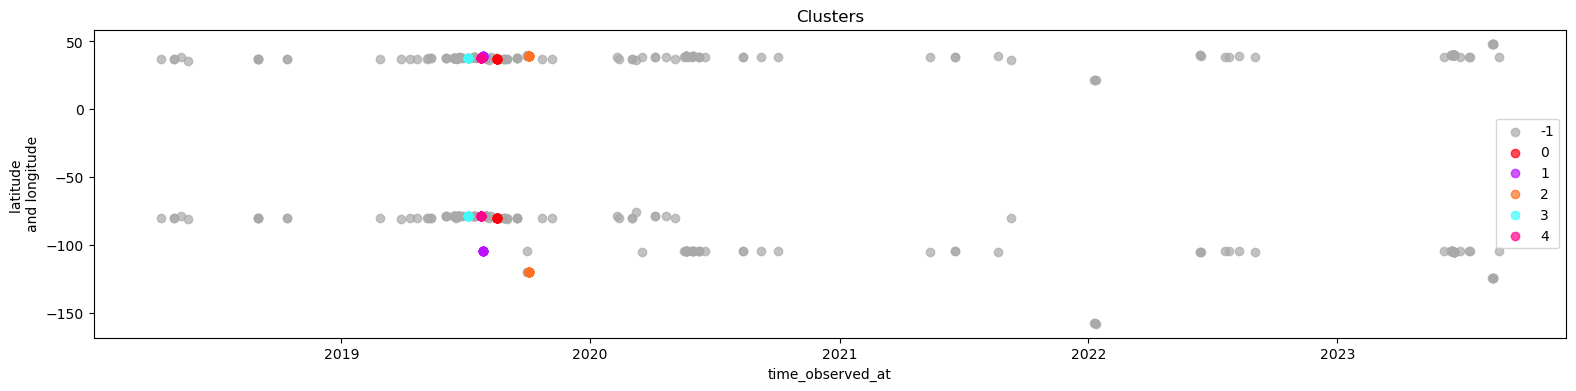

In [29]:
cluster_overview("Artif_Cluster")

Looks like all of the users spurts of several observations in a day happened in 2019. You can see the corresponding lat/lon happening for each cluster.

In [30]:
fig = px.scatter_3d(rand_user_df, x='latitude', y='longitude', z='time_observed_at',
              color='Artif_Cluster')
fig.show()

In [31]:
non_noise_df = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
fig = px.scatter_3d(non_noise_df, x='latitude', y='longitude', z='time_observed_at',
              color='Artif_Cluster')
fig.show()

# Comment this definition to explain it

In [32]:
def cluster_views(col, df = rand_user_df, x = "latitude", y = "longitude", z = "obs_time_conv_(minutes)"):
    '''
    something here
    '''  
    
    labels = np.sort(df[col].unique()) 

    
    # find the biggest diff of lat, lon and time for all clusters
    # to make all windows for graphs cover the same approximate area
    lat_diff = 0
    lon_diff = 0
    time_diff = 0
    for i in labels:
        if i <= 0:
            continue
        cluster = df[df[col] == i]
        x_diff = cluster[x].max() - cluster[x].min()
        if x_diff > lat_diff:
            lat_diff = x_diff
        y_diff = cluster[y].max() - cluster[y].min()
        if y_diff > lon_diff:
            lon_diff = y_diff
        z_diff = cluster[z].max() - cluster[z].min()
        if z_diff > time_diff:
            time_diff = z_diff

    # graph all clusters
    # num of rows:
    r = len(labels) - 1

    #set up axes for subplots
    plt.subplots(r, 2, figsize=(8, 25))
    # space between subplots (code from geeks for geeks)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.5)

    sub_num = 1
    for i in labels:
        if i == -1:
            continue
        cluster = df[df[col] == i]
        min_x = cluster[x].min() - 0.001
        max_x = cluster[x].min() + lat_diff + 0.001
        min_y = cluster[y].min() - 0.001
        max_y = cluster[y].min() + lon_diff + 0.001
        min_z = cluster[z].min() - 10
        max_z = cluster[z].min() + time_diff + 10


        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[x], cluster[y], c = '#0096FF')
        plt.title(f'Cluster {i} has {cluster.shape[0]} points')
        plt.xlabel(x)
        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1

        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[z], cluster[y], c = '#EE4B2B')
        #plt.title(f'Cluster {i} has {cluster.shape[0]} points')
        plt.xlabel(z)
        plt.xlim(min_z, max_z)
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1

    plt.show()

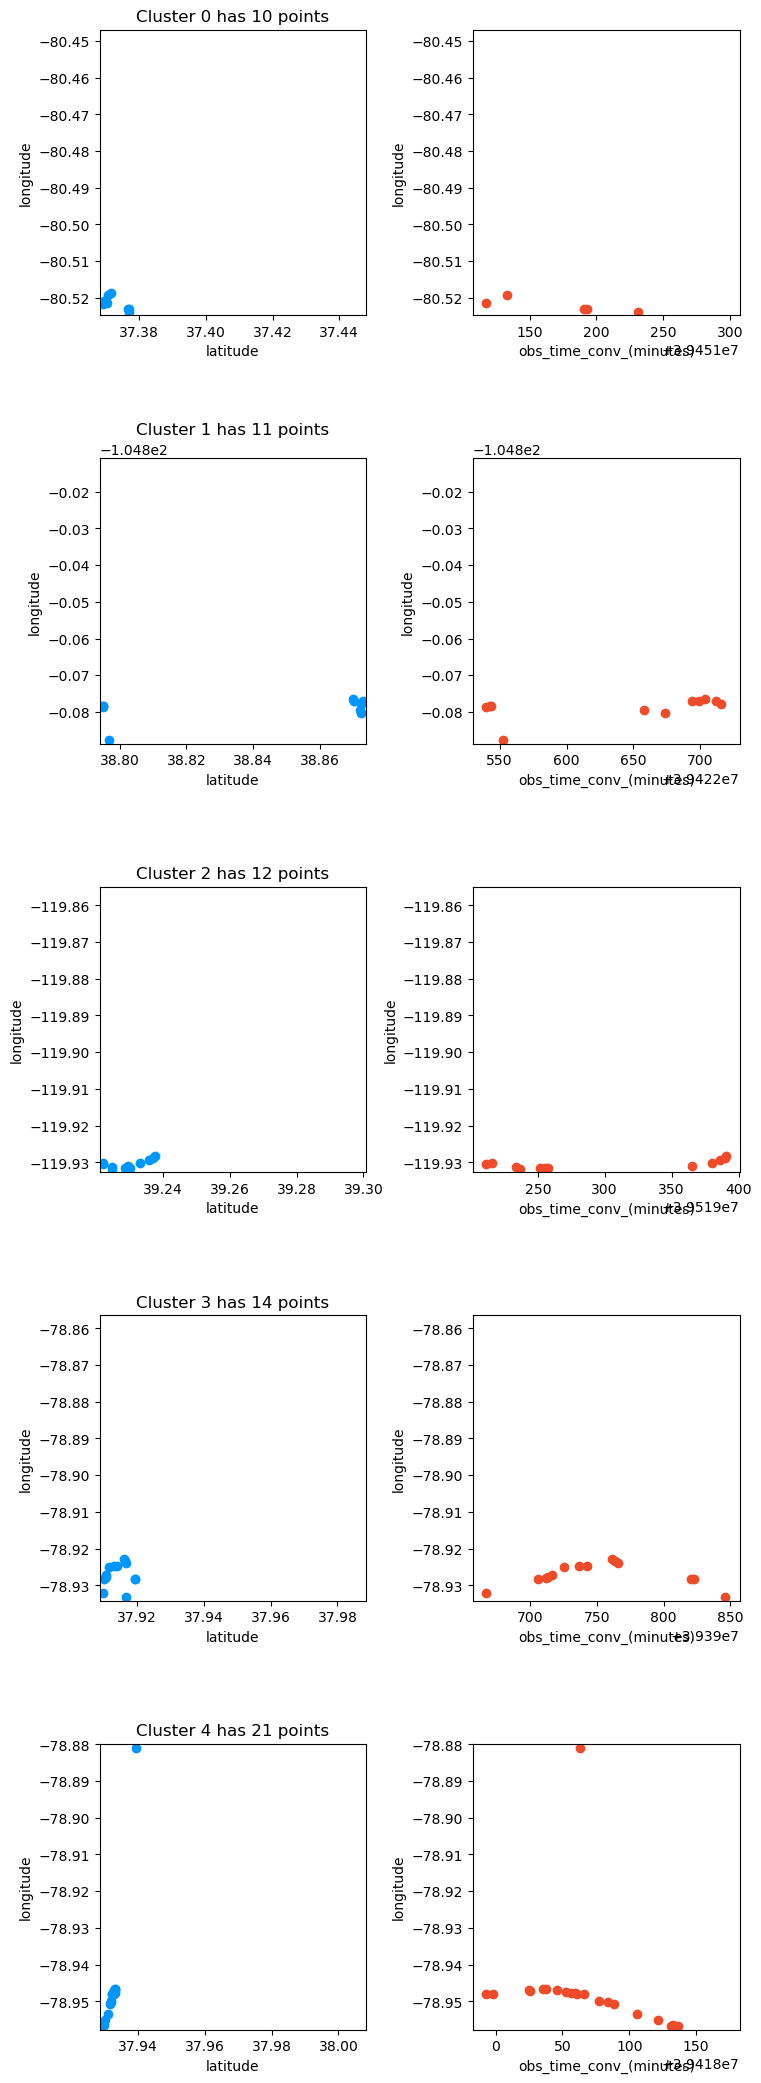

In [33]:
cluster_views("Artif_Cluster")

## Exploratory DBSCAN
Initial look at how DBSCAN performs compared to the baseline analytics model depending on the features chosen for analyzing. No concern for hyperparameters yet. 

### Continuous Time-Related Columns

In [34]:
# continuous columns only

init_db_col = ['id', 'latitude',
       'longitude', 'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'created_at_conv_(minutes)']
init_db_df = rand_user_df[init_db_col]


In [35]:
# use MinMaxScaler to give better meaning to the eps value
# and make distances smaller to compute

mms = MinMaxScaler()
init_db_df_mms = mms.fit_transform(init_db_df)


In [36]:
dbscan_model_01 = DBSCAN(eps=.1, min_samples=10)

# Fit and get labels
cluster_labels_01 = dbscan_model_01.fit_predict(init_db_df_mms)

In [37]:
len(np.unique(cluster_labels_01)) - 1

5

In [38]:
rand_user_df["Cluster_Label"] = cluster_labels_01
rand_user_df.sample(3)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\1953031401.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id                       observed_on_string observed_on  \
69    29452048  Wed Jul 24 2019 10:30:44 GMT-0400 (EDT)  2019-07-24   
208  168568362                2023-06-20 09:01:06-06:00  2023-06-20   
83    29600023  Fri Jul 26 2019 12:10:37 GMT-0400 (EDT)  2019-07-26   

             time_observed_at                    time_zone  user_id  \
69  2019-07-24 14:30:44+00:00   Eastern Time (US & Canada)   923056   
208 2023-06-20 15:01:06+00:00  Mountain Time (US & Canada)   923056   
83  2019-07-26 16:10:37+00:00   Eastern Time (US & Canada)   923056   

                   created_at quality_grade  \
69  2019-07-24 16:54:16+00:00      needs_id   
208 2023-06-20 22:55:23+00:00      needs_id   
83  2019-07-26 22:02:21+00:00      research   

                                                   url  \
69   https://www.inaturalist.org/observations/29452048   
208  https://www.inaturalist.org/observations/16856...   
83   https://www.inaturalist.org/observations/29600023   

                                             image_url  ... obs_year  \
69   https://static.inaturalist.org/photos/45964826...  ...     2019   
208  https://static.inaturalist.org/photos/29215331...  ...     2023   
83   https://static.inaturalist.org/photos/46204275...  ...     2019   

     obs_month  obs_day  obs_hour  created_year  created_month  created_day  \
69           7       24        14          2019              7           24   
208          6       20        15          2023              6           20   
83           7       26        16          2019              7           26   

     created_hour  Artif_Cluster Cluster_Label  
69             16              4             0  
208            22             -1             4  
83             22             -1             0  

[3 rows x 41 columns]

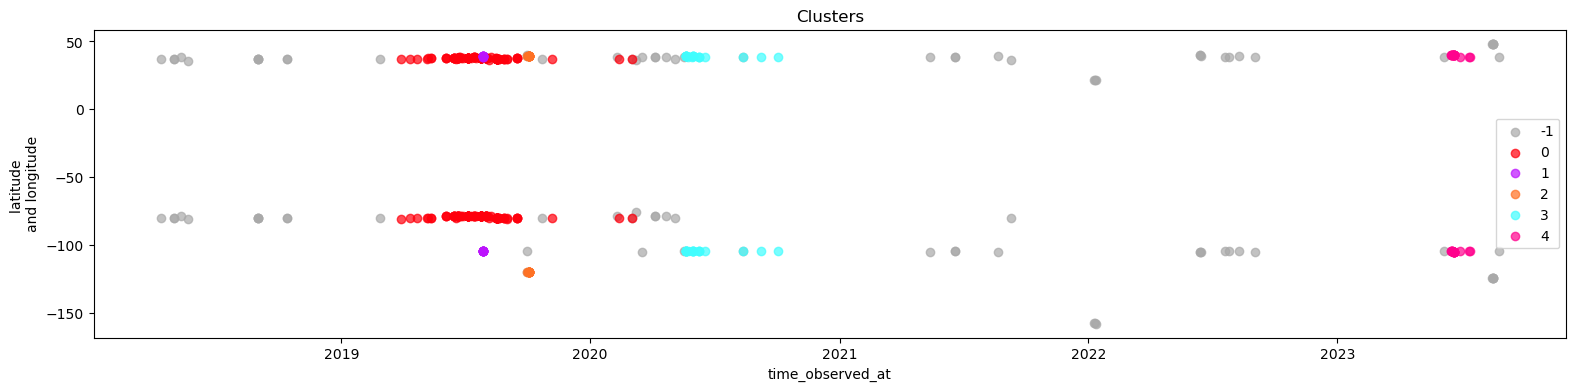

In [39]:
cluster_overview("Cluster_Label")

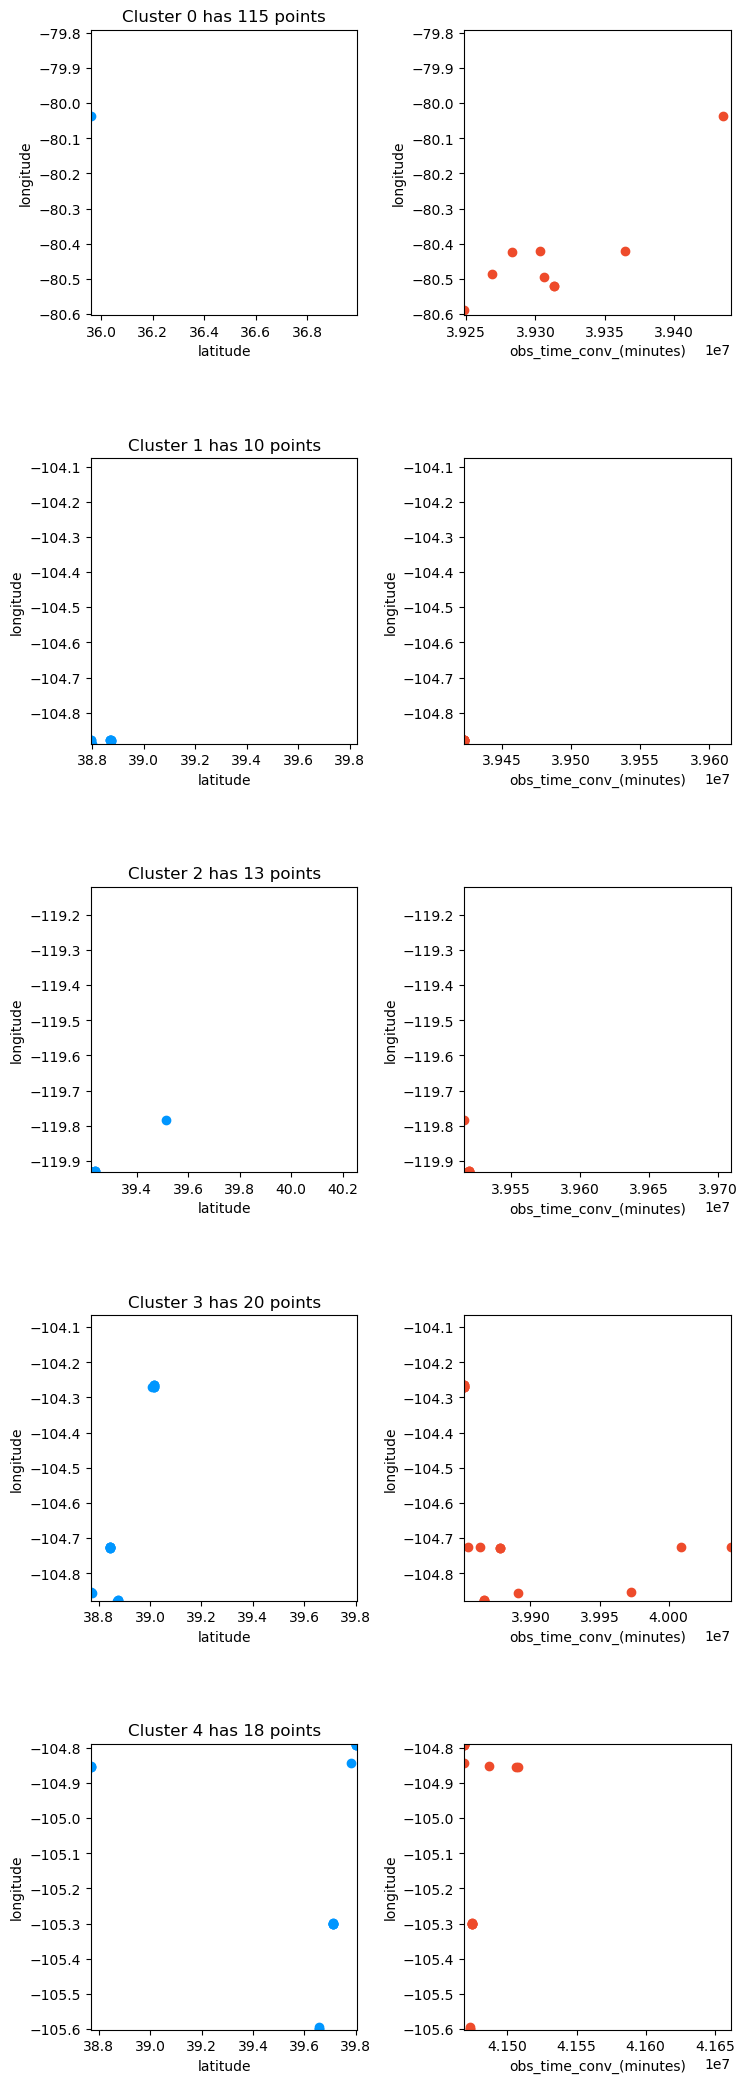

In [40]:
cluster_views("Cluster_Label")

In [41]:
# silhouette score of baseline non-ML model using the same columns as db_01 used

non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]

artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()
init_db_df_array = non_noise[init_db_col].to_numpy()

silhouette_score(init_db_df_array, artificial_cluster_array)

0.9886512196271166

In [42]:
# silhouette score of dbscan_model_01 (using unscaled data to compare to above)

cluster_labels = dbscan_model_01.fit_predict(init_db_df_mms)
    
silhouette_score(init_db_df[cluster_labels != -1], cluster_labels[cluster_labels != -1])


0.048969655362951524

Continuous on its own seems to finds the "big clusters" -- when this user was active vs. inactive (although what is happening with Cluster 6 is confusing). Also performs signficantly worse on silhouette score than my model (although, in fairness, it seemed to be "focused" on some other kind of grouping, so not sure the two numbers are worth comparing). 

### Discrete Time Columns

In [43]:
db_df_2 = rand_user_df[['latitude', 'longitude', 'obs_month', 'obs_day', 'obs_hour', 'obs_year',
       'created_year', 'created_month', 'created_day', 'created_hour']]

In [44]:
mms = MinMaxScaler()
db_df_2_mms = mms.fit_transform(db_df_2)

dbscan_model_02 = DBSCAN(eps=.1, min_samples=10)

# Fit and get labels
cluster_labels_02 = dbscan_model_02.fit_predict(db_df_2_mms)

In [45]:
len(np.unique(cluster_labels_02)) - 1

2

In [46]:
rand_user_df["Cluster_Label"] = cluster_labels_02


C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2790669217.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



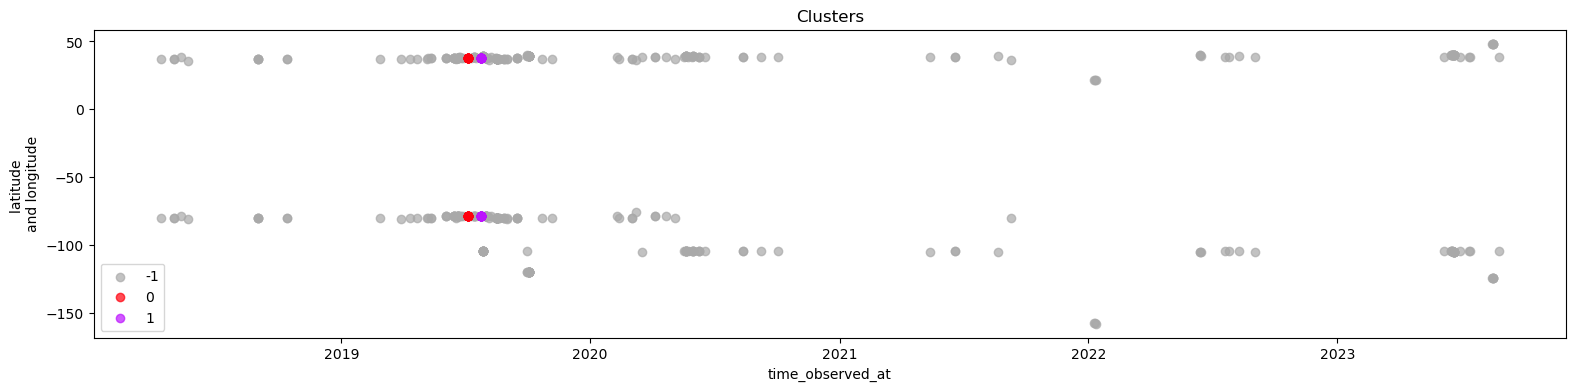

In [47]:
cluster_overview("Cluster_Label")

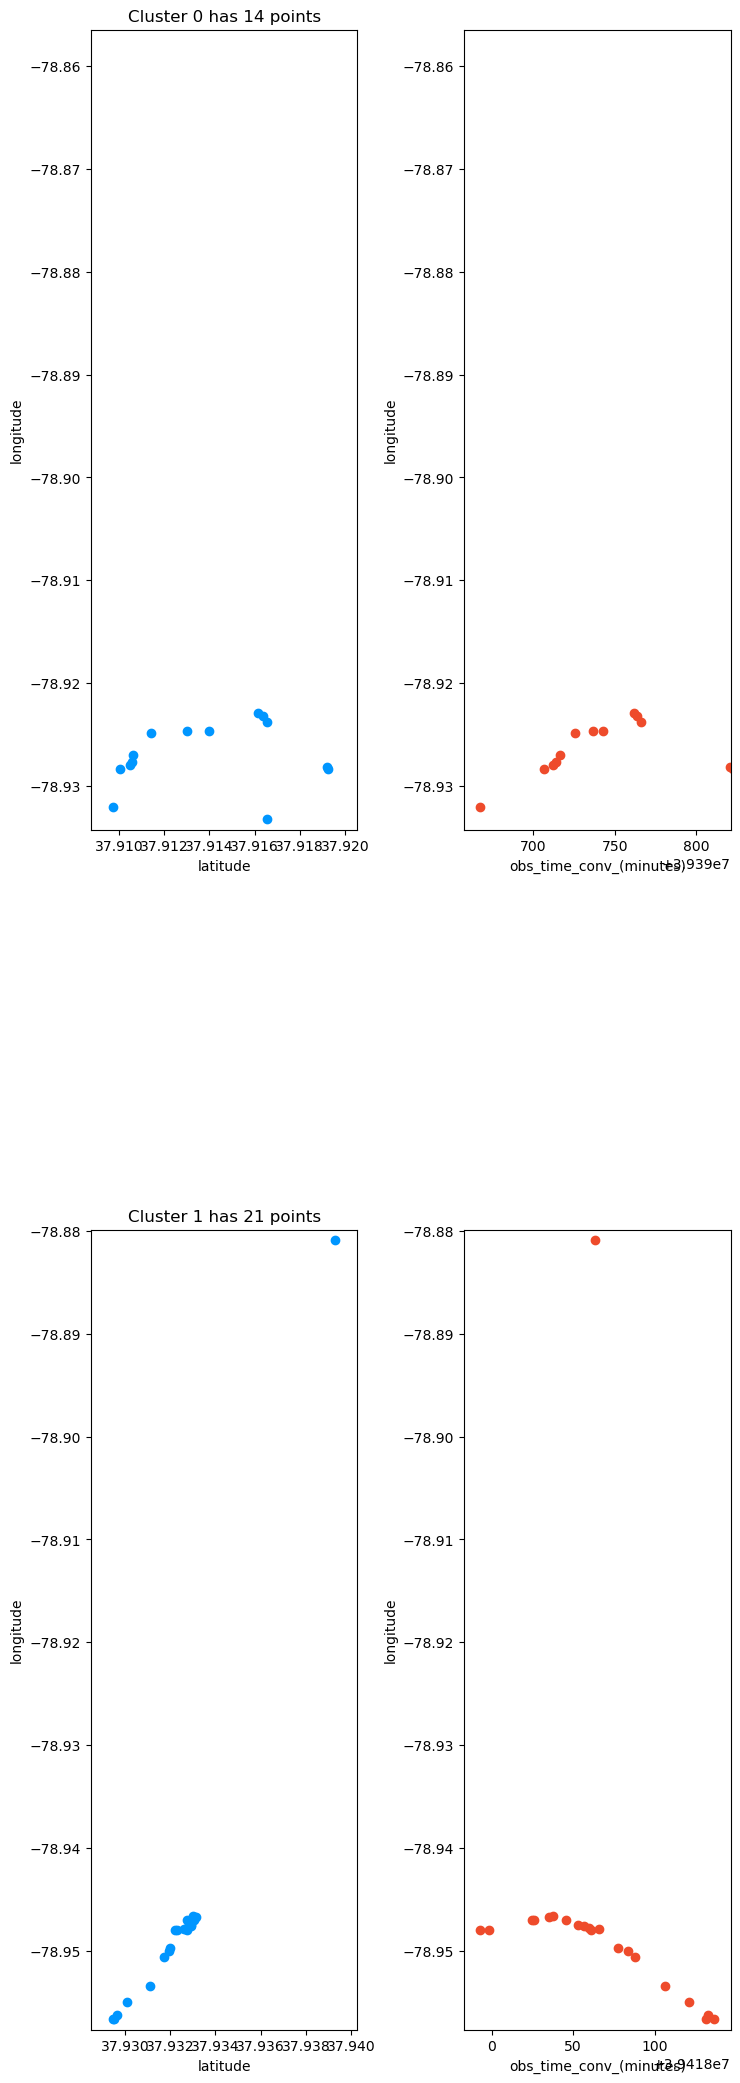

In [48]:
cluster_views("Cluster_Label")

In [49]:
# silhouette score of baseline non-ML model using the same columns as db_02 used
# next two lines defined in previous block but commented out here in case

#non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
#artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()

db_df_2_array = non_noise[db_df_2.columns].to_numpy()

silhouette_score(db_df_2_array, artificial_cluster_array)

0.8599262461123098

In [50]:
# silhouette score of dbscan_model_02 on unscaled data for comparison
    
silhouette_score(db_df_2[cluster_labels_02 != -1], cluster_labels_02[cluster_labels_02 != -1])

0.9676620461307004

OK Discrete columns seem to do well here--it only found 4 clusters but likely pretty solid "hikes". Will be curious to drill into that more closely to what it found.

### Combo Time Columns


In [51]:
# chose four features from each
db_df_3 = rand_user_df[['id', 'latitude',
       'longitude', 'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'obs_year',
       'obs_month', 'obs_day', 'obs_hour']]

In [52]:
mms = MinMaxScaler()
db_df_3_mms = mms.fit_transform(db_df_3)

dbscan_model_03 = DBSCAN(eps=.1, min_samples=10)

# Fit and get labels
cluster_labels_03 = dbscan_model_03.fit_predict(db_df_3_mms)

In [53]:
len(np.unique(cluster_labels_03)) - 1

5

In [54]:
rand_user_df["Cluster_Label"] = cluster_labels_03

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\1988594208.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



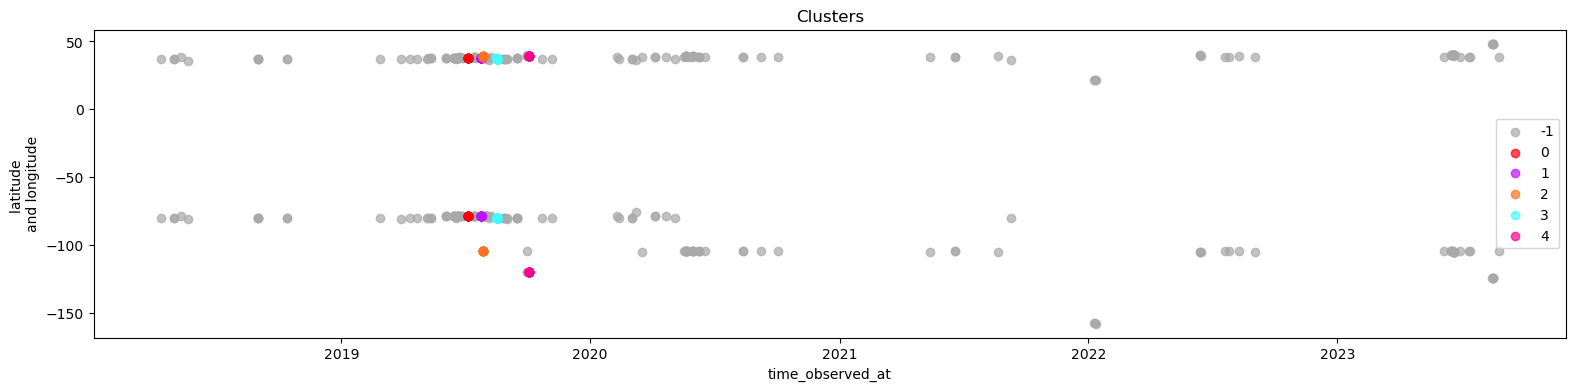

In [55]:
cluster_overview("Cluster_Label")

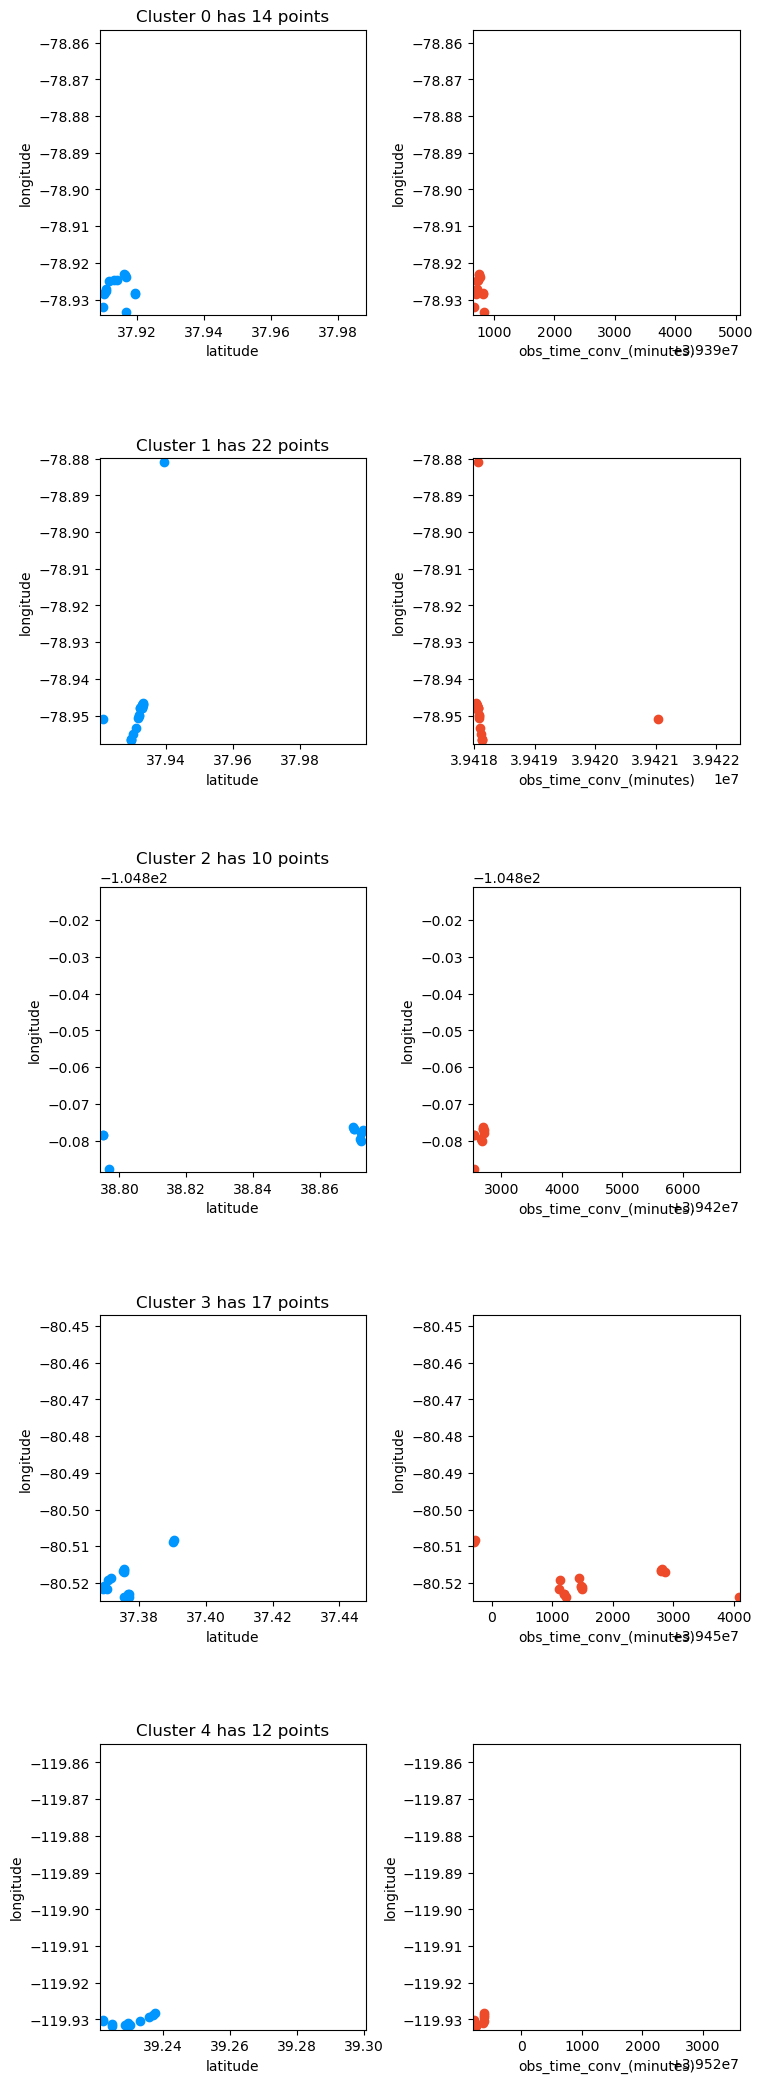

In [56]:
cluster_views("Cluster_Label")

In [57]:
# silhouette score of baseline non-ML model using the same columns as db_03 used
# next two lines defined in previous block but commented out here in case

#non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
#artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()

db_df_3_array = non_noise[db_df_3.columns].to_numpy()

silhouette_score(db_df_3_array, artificial_cluster_array)

0.9886498749588256

In [58]:
# silhouette score of dbscan_model_03 on unscaled data for comparison
    
silhouette_score(db_df_3[cluster_labels_03 != -1], cluster_labels_03[cluster_labels_03 != -1])

0.9511129466433257

This found 6 groups--so more like my own model, but the score is much worse. (And my score is best on this set of features--not sure what to make of that). Regardless, it looks like we need the discrete times to help the model. Not sure if we need the continuous times. 

## Optimizing Stage 1

### Feature Selection
Testing different sets of time- and distance- related features against each other. 

First I'm creating a function df_feat_sel() for choosing a slice of the user-specific dataframe based on feature selections. This way I can put the function in an optimization loop.

In [59]:
# Part of a help function for df_feat_sel

def feat_sel_param(i):
    '''
    Takes an integer and returns the feature selection information.
    Meant to be used as part of 'help' for using the feat_sel function
    as a way of knowing what features each integer is associated with.
    
    Arguments:
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    Returns:
    Tuple with first element a string that acts as a descriptive title of the selected features
    and second element a list of the column headings for features chosen for that description
    
    '''
    # Creating the dictionary for feature selection
    # feature_sel_options dictionary should match that of df_feat_sel() function
    feature_sel_options = {}

    feature_sel_options[0] = ("continuous_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)'])

    feature_sel_options[1] = ("continuous_light",
                              ['latitude','longitude', 
                               'km_diff','obs_time_conv_(minutes)'])

    feature_sel_options[2] = ("discrete_heavy",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year',
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[3] = ("discrete_light",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year'])

    # including this one to imitate the features I used for my own baseline model
    feature_sel_options[4] = ("discrete_barebones",
                              ['obs_month', 'obs_day', 'obs_year'])

    feature_sel_options[5] = ("combo_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year', 
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[6] = ("combo_light", 
                              ['latitude', 'longitude', 
                               'minute_diff', 'km_diff',  
                               'obs_month', 'obs_day', 'obs_year'])
    
    # returns feature selection values if i is appropriate/exists as key
    # (also allowing user to also save and access the column lists without the df_feat_sel feature)
    if i in range(len(feature_sel_options)):
        return feature_sel_options[i]
    # but prints helpful info if i is not a dictionary key
    else:
        print(f'Input needs to be an integer between 0 and {len(feature_sel_options) - 1}')



In [60]:
def df_feat_sel(df, i):
    
    '''
    Takes a user-specific dataframe (df) and an integer mapped to a specific set of features
    and returns a dataframe for cluster analysis. 
    
    Arguments:
    df -- name of user-specific dataframe from the df_sp dataframe (after discrete time columns have been added)
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    For a reminder of what i maps to, use feat_sel_param() function
    
    Returns:
    Dataframe slice of original dataframe with only the columns chosen for feature selection
    
    '''
    
    sel_df = df[feat_sel_param(i)[1]]
   

    return sel_df

### Feature and Hyperparameter Optimization

In [61]:
# choosing all columns with non boolean numeric columns 
# to create a dataframe on which to compare "absolute" silhouette scores
# from one cluster to the other

absolute_columns = ['id', 'num_identification_agreements',
       'num_identification_disagreements', 'latitude',
       'longitude', 'positional_accuracy', 'public_positional_accuracy',
       'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 'obs_year',
       'obs_month', 'obs_day', 'obs_hour', 'created_year', 'created_month',
       'created_day', 'created_hour'] 

absolute_df_for_scoring = rand_user_df[absolute_columns]
    
#empty dataframe for analysis of silhouette scores
sil_scores = pd.DataFrame()
index = 0 # indexing unit for dataframe

# i loops through the different feature selections
for i in range(7):
    # create slice of dataframe for modeling with feature_code
    subset = df_feat_sel(rand_user_df, i)
    
    # scale data --choosing MinMaxScaler to make it easier to guess at good values for DBSCAN eps
    mms = MinMaxScaler()
    subset_scaled = mms.fit_transform(subset)
    
    # looping through choices for eps and min_samples for DBSCAN
    for e in [.001, .005, .01, .05, .1, .25, .5, .75]:
        for m in [10, 9, 8, 7, 6, 5]: # going down so that Artif_Cluster will end on most clusters found
            
            # creating baseline set given min_sample of m
            top_dates = potential_hikes[potential_hikes.values >= m].index
            
            artificial_cluster = {}
            n = 0
            for day in top_dates:
                artificial_cluster[day] = n
                n += 1
            artificial_cluster
            
            for ind in range(rand_user_df.shape[0]):
                # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
                if rand_user_df.loc[ind, "time_observed_at"].strftime('%D') in top_dates:
                    rand_user_df.loc[ind, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[ind, "time_observed_at"].strftime('%D')]
                # otherwise, the new column will be assigned a -1 (the way DBSCAN does for non clusters)
                else:
                    rand_user_df.loc[ind, "Artif_Cluster"] = -1
            rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)
            
            # for silhouette score of artificial cluster, relative to chosen subset
            non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
            artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()
            baseline_relative = non_noise[subset.columns].to_numpy()
            baseline_rel_sil = silhouette_score(baseline_relative, artificial_cluster_array)
            
            
            
            #instantiate model
            dbscan_model = DBSCAN(eps=e, min_samples=m)
            # Fit and get labels
            cluster_labels = dbscan_model.fit_predict(subset_scaled)
            num_clusters = len(np.unique(cluster_labels)) - 1 # subtract one for noise
            
            
            # silhouette scores for db
            if num_clusters > 1: # silhouette scores require at least two groups to analyze 
                # silhouette score relative to the subset columns
                db_rel_sil = silhouette_score(subset[cluster_labels != -1], cluster_labels[cluster_labels != -1])
                # silhouette score relative to the "absolute" dataset created at top of cell
                db_abs_sil = silhouette_score(absolute_df_for_scoring[cluster_labels != -1], cluster_labels[cluster_labels != -1])
            else: 
                db_rel_sil = np.NaN
                db_abs_sil = np.NaN

                
            
            # store info in analysis dataframe
            sil_scores.loc[index, "feature_code"] = i
            sil_scores.loc[index, "eps"] = e
            sil_scores.loc[index, "min_samples"] = m
            sil_scores.loc[index, "baseline_rel_silhouette"] = baseline_rel_sil
            sil_scores.loc[index, "db_rel_silhouette"] = db_rel_sil
            sil_scores.loc[index, "db_abs_silhouette"] = db_abs_sil
            sil_scores.loc[index, "num_db_clusters"] = num_clusters
            sil_scores.loc[index, "num_bl_clusters"] = len(np.unique(artificial_cluster_array))
            index += 1

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\2582751470.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [62]:
baseline_absolute = non_noise[absolute_df_for_scoring.columns].to_numpy()
baseline_abs_sil = silhouette_score(baseline_absolute, artificial_cluster_array)
print(f'Overall baseline absolute silhouette score is {baseline_abs_sil}. \n For relative scores look at sil_scores dataframe.')

Overall baseline absolute silhouette score is 0.9760600129707622. 
 For relative scores look at sil_scores dataframe.


In [63]:
# Overview of set for not null scores
sil_scores[sil_scores["db_rel_silhouette"].notnull()].describe()

feature_code         eps  min_samples  baseline_rel_silhouette  \
count    230.000000  230.000000   230.000000               230.000000   
mean       2.947826    0.105635     7.326087                 0.720512   
std        2.059565    0.139594     1.718819                 0.516748   
min        0.000000    0.001000     5.000000                -0.508274   
25%        1.000000    0.005000     6.000000                 0.833265   
50%        3.000000    0.050000     7.000000                 0.976286   
75%        5.000000    0.100000     9.000000                 0.989536   
max        6.000000    0.500000    10.000000                 1.000000   

       db_rel_silhouette  db_abs_silhouette  num_db_clusters  num_bl_clusters  
count         230.000000         230.000000       230.000000       230.000000  
mean            0.521381           0.628936         6.113043         7.765217  
std             0.496249           0.424433         2.731876         2.574074  
min            -0.670525          -0.582005         2.000000         5.000000  
25%             0.197180           0.338297         5.000000         6.000000  
50%             0.627705           0.895845         6.000000         6.000000  
75%             0.982985           0.989223         8.000000        11.000000  
max             1.000000           0.999706        14.000000        11.000000

Describe table shows there are times dbscan outperforms my baseline model

In [64]:
# What do the top scores look like?
top_abs_db_scores = sil_scores[(sil_scores["db_rel_silhouette"].notnull())].sort_values(by = "db_abs_silhouette").tail(20)
top_abs_db_scores

feature_code    eps  min_samples  baseline_rel_silhouette  \
290           6.0  0.001          8.0                -0.455298   
163           3.0  0.050          9.0                 0.889808   
164           3.0  0.050          8.0                 0.889808   
115           2.0  0.050          9.0                 0.867580   
259           5.0  0.050          9.0                 0.989536   
260           5.0  0.050          8.0                 0.989536   
116           2.0  0.050          8.0                 0.867580   
289           6.0  0.001          9.0                -0.455298   
114           2.0  0.050         10.0                 0.859926   
258           5.0  0.050         10.0                 0.988651   
162           3.0  0.050         10.0                 0.889824   
264           5.0  0.100         10.0                 0.988651   
120           2.0  0.100         10.0                 0.859926   
288           6.0  0.001         10.0                -0.412696   
257           5.0  0.010          5.0                 0.976286   
251           5.0  0.005          5.0                 0.976286   
256           5.0  0.010          6.0                 0.976286   
250           5.0  0.005          6.0                 0.976286   
244           5.0  0.001          6.0                 0.976286   
245           5.0  0.001          5.0                 0.976286   

     db_rel_silhouette  db_abs_silhouette  num_db_clusters  num_bl_clusters  
290           0.264655           0.997594              5.0              6.0  
163           0.925755           0.997847              3.0              6.0  
164           0.925755           0.997847              3.0              6.0  
115           0.943115           0.997847              3.0              6.0  
259           0.998085           0.997847              3.0              6.0  
260           0.998085           0.997847              3.0              6.0  
116           0.943115           0.997847              3.0              6.0  
289           0.383376           0.998050              4.0              6.0  
114           0.970694           0.998645              2.0              5.0  
258           0.998768           0.998645              2.0              5.0  
162           0.962866           0.998645              2.0              5.0  
264           0.998791           0.998671              2.0              5.0  
120           0.967662           0.998671              2.0              5.0  
288           0.563919           0.999196              3.0              5.0  
257           0.999504           0.999277              8.0             11.0  
251           0.999687           0.999456              8.0             11.0  
256           0.999680           0.999494              3.0             11.0  
250           0.999845           0.999598              2.0             11.0  
244           0.999845           0.999598              2.0             11.0  
245           0.999823           0.999706              6.0             11.0

In [65]:
top_abs_db_scores["feature_code"].value_counts()

5.0    10
2.0     4
6.0     3
3.0     3
Name: feature_code, dtype: int64

In [66]:
top_rel_db_scores = sil_scores[(sil_scores["db_rel_silhouette"].notnull())].sort_values(by = "db_rel_silhouette").tail(20)
top_rel_db_scores

feature_code    eps  min_samples  baseline_rel_silhouette  \
250           5.0  0.005          6.0                 0.976286   
244           5.0  0.001          6.0                 0.976286   
201           4.0  0.005          7.0                 1.000000   
204           4.0  0.010         10.0                 1.000000   
209           4.0  0.010          5.0                 1.000000   
208           4.0  0.010          6.0                 1.000000   
207           4.0  0.010          7.0                 1.000000   
203           4.0  0.005          5.0                 1.000000   
202           4.0  0.005          6.0                 1.000000   
200           4.0  0.005          8.0                 1.000000   
205           4.0  0.010          9.0                 1.000000   
198           4.0  0.005         10.0                 1.000000   
197           4.0  0.001          5.0                 1.000000   
196           4.0  0.001          6.0                 1.000000   
195           4.0  0.001          7.0                 1.000000   
194           4.0  0.001          8.0                 1.000000   
193           4.0  0.001          9.0                 1.000000   
192           4.0  0.001         10.0                 1.000000   
199           4.0  0.005          9.0                 1.000000   
206           4.0  0.010          8.0                 1.000000   

     db_rel_silhouette  db_abs_silhouette  num_db_clusters  num_bl_clusters  
250           0.999845           0.999598              2.0             11.0  
244           0.999845           0.999598              2.0             11.0  
201           1.000000           0.989223              6.0              6.0  
204           1.000000           0.988297              5.0              5.0  
209           1.000000           0.976060             11.0             11.0  
208           1.000000           0.976060             11.0             11.0  
207           1.000000           0.989223              6.0              6.0  
203           1.000000           0.976060             11.0             11.0  
202           1.000000           0.976060             11.0             11.0  
200           1.000000           0.989223              6.0              6.0  
205           1.000000           0.989223              6.0              6.0  
198           1.000000           0.988297              5.0              5.0  
197           1.000000           0.976060             11.0             11.0  
196           1.000000           0.976060             11.0             11.0  
195           1.000000           0.989223              6.0              6.0  
194           1.000000           0.989223              6.0              6.0  
193           1.000000           0.989223              6.0              6.0  
192           1.000000           0.988297              5.0              5.0  
199           1.000000           0.989223              6.0              6.0  
206           1.000000           0.989223              6.0              6.0

In [67]:
top_rel_db_scores["feature_code"].value_counts()

4.0    18
5.0     2
Name: feature_code, dtype: int64

In [68]:
comparative_top = sil_scores[sil_scores["db_rel_silhouette"] > sil_scores["baseline_rel_silhouette"]].sort_values(by = "db_rel_silhouette").tail(20)
comparative_top

feature_code    eps  min_samples  baseline_rel_silhouette  \
148           3.0  0.001          6.0                 0.833265   
155           3.0  0.005          5.0                 0.833265   
161           3.0  0.010          5.0                 0.833265   
149           3.0  0.001          5.0                 0.833265   
259           5.0  0.050          9.0                 0.989536   
260           5.0  0.050          8.0                 0.989536   
258           5.0  0.050         10.0                 0.988651   
264           5.0  0.100         10.0                 0.988651   
107           2.0  0.005          5.0                 0.762117   
101           2.0  0.001          5.0                 0.762117   
113           2.0  0.010          5.0                 0.762117   
112           2.0  0.010          6.0                 0.762117   
106           2.0  0.005          6.0                 0.762117   
100           2.0  0.001          6.0                 0.762117   
257           5.0  0.010          5.0                 0.976286   
256           5.0  0.010          6.0                 0.976286   
251           5.0  0.005          5.0                 0.976286   
245           5.0  0.001          5.0                 0.976286   
250           5.0  0.005          6.0                 0.976286   
244           5.0  0.001          6.0                 0.976286   

     db_rel_silhouette  db_abs_silhouette  num_db_clusters  num_bl_clusters  
148           0.996393           0.693992              7.0             11.0  
155           0.996815           0.624679             10.0             11.0  
161           0.996815           0.624679             10.0             11.0  
149           0.996815           0.624679             10.0             11.0  
259           0.998085           0.997847              3.0              6.0  
260           0.998085           0.997847              3.0              6.0  
258           0.998768           0.998645              2.0              5.0  
264           0.998791           0.998671              2.0              5.0  
107           0.999114           0.836779              9.0             11.0  
101           0.999114           0.836779              9.0             11.0  
113           0.999114           0.836779              9.0             11.0  
112           0.999421           0.997097              5.0             11.0  
106           0.999421           0.997097              5.0             11.0  
100           0.999421           0.997097              5.0             11.0  
257           0.999504           0.999277              8.0             11.0  
256           0.999680           0.999494              3.0             11.0  
251           0.999687           0.999456              8.0             11.0  
245           0.999823           0.999706              6.0             11.0  
250           0.999845           0.999598              2.0             11.0  
244           0.999845           0.999598              2.0             11.0

In [69]:
comparative_top["feature_code"].value_counts()

5.0    10
2.0     6
3.0     4
Name: feature_code, dtype: int64

# Visualizing Top Model(s)

In [70]:
i = 5
subset = df_feat_sel(rand_user_df, i)

# scale data --choosing MinMaxScaler to make it easier to guess at good values for DBSCAN eps
mms = MinMaxScaler()
subset_scaled = mms.fit_transform(subset)

e = .005
m = 5


#instantiate model
dbscan_model = DBSCAN(eps=e, min_samples=m)
# Fit and get labels
cluster_labels = dbscan_model.fit_predict(subset_scaled)
num_clusters = len(np.unique(cluster_labels)) - 1 # subtract one for noise
rand_user_df["Cluster_Label"] = cluster_labels

C:\Users\lisa_\AppData\Local\Temp\ipykernel_42388\737577280.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



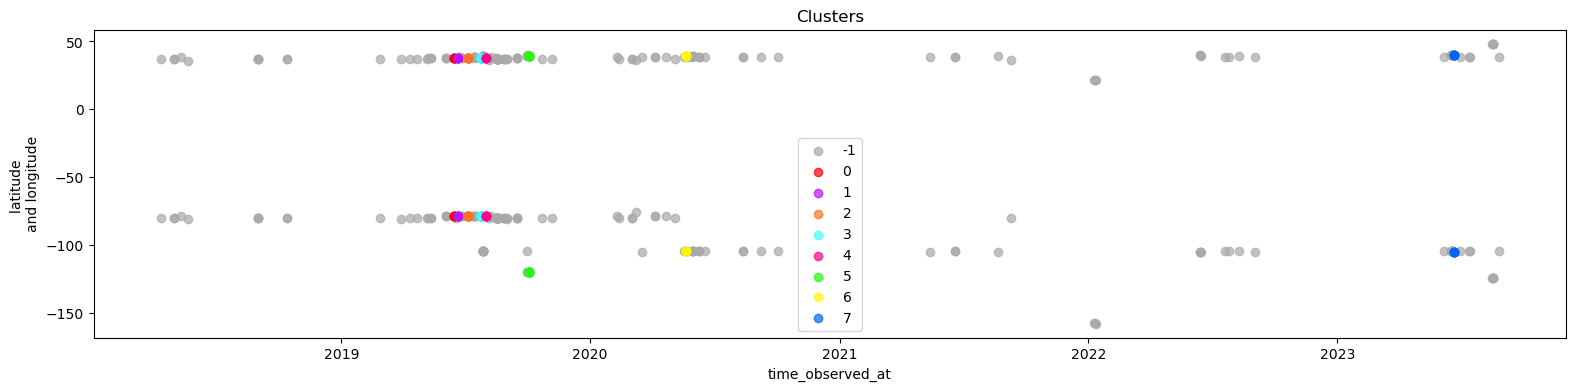

In [71]:
cluster_overview("Cluster_Label")

In [72]:
non_noise_df = rand_user_df[rand_user_df["Cluster_Label"] != -1]
fig = px.scatter_3d(non_noise_df, x='latitude', y='longitude', z='time_observed_at',
              color='Cluster_Label')
fig.show()

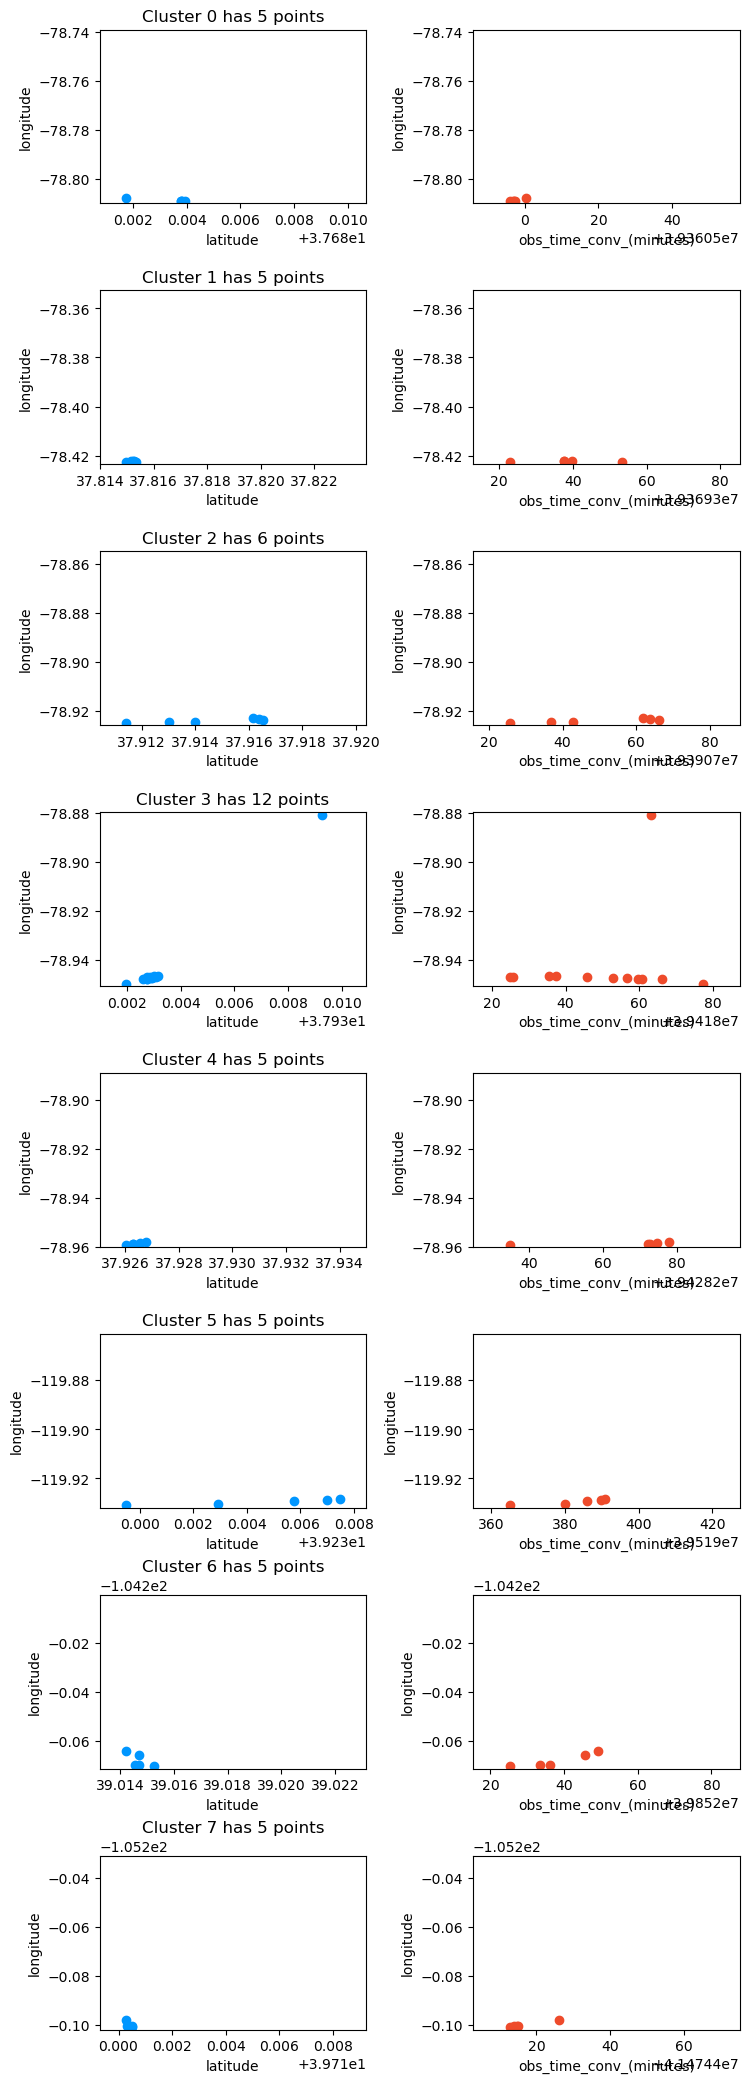

In [73]:
cluster_views("Cluster_Label")

In [74]:
rand_user_df[rand_user_df["Cluster_Label"] != -1]

id                       observed_on_string observed_on  \
23    26976069  Fri Jun 14 2019 11:13:57 GMT-0400 (EDT)  2019-06-14   
24    26976094  Fri Jun 14 2019 11:14:43 GMT-0400 (EDT)  2019-06-14   
25    26976117  Fri Jun 14 2019 11:15:05 GMT-0400 (EDT)  2019-06-14   
26    26976137  Fri Jun 14 2019 11:15:16 GMT-0400 (EDT)  2019-06-14   
27    26976332  Fri Jun 14 2019 11:18:23 GMT-0400 (EDT)  2019-06-14   
32    27345074  Thu Jun 20 2019 14:20:53 GMT-0400 (EDT)  2019-06-20   
33    27345124  Thu Jun 20 2019 14:35:35 GMT-0400 (EDT)  2019-06-20   
34    27345243  Thu Jun 20 2019 14:35:40 GMT-0400 (EDT)  2019-06-20   
35    27345269  Thu Jun 20 2019 14:37:42 GMT-0400 (EDT)  2019-06-20   
36    27345362  Thu Jun 20 2019 14:51:27 GMT-0400 (EDT)  2019-06-20   
46    28244543  Fri Jul 05 2019 11:03:40 GMT-0400 (EDT)  2019-07-05   
47    28244571  Fri Jul 05 2019 11:14:48 GMT-0400 (EDT)  2019-07-05   
48    28244611  Fri Jul 05 2019 11:20:50 GMT-0400 (EDT)  2019-07-05   
49    28244664  Fri Jul 05 2019 11:39:47 GMT-0400 (EDT)  2019-07-05   
50    28244739  Fri Jul 05 2019 11:41:38 GMT-0400 (EDT)  2019-07-05   
51    28244881  Fri Jul 05 2019 11:44:05 GMT-0400 (EDT)  2019-07-05   
64    29451707  Wed Jul 24 2019 10:02:51 GMT-0400 (EDT)  2019-07-24   
65    29451861  Wed Jul 24 2019 10:03:43 GMT-0400 (EDT)  2019-07-24   
66    29451902  Wed Jul 24 2019 10:13:29 GMT-0400 (EDT)  2019-07-24   
67    29451964  Wed Jul 24 2019 10:15:23 GMT-0400 (EDT)  2019-07-24   
68    29451992  Wed Jul 24 2019 10:23:41 GMT-0400 (EDT)  2019-07-24   
69    29452048  Wed Jul 24 2019 10:30:44 GMT-0400 (EDT)  2019-07-24   
70    29452097  Wed Jul 24 2019 10:34:44 GMT-0400 (EDT)  2019-07-24   
71    29452135  Wed Jul 24 2019 10:37:42 GMT-0400 (EDT)  2019-07-24   
72    29452185  Wed Jul 24 2019 10:38:47 GMT-0400 (EDT)  2019-07-24   
73    29452212  Wed Jul 24 2019 10:41:07 GMT-0400 (EDT)  2019-07-24   
74    29452244  Wed Jul 24 2019 10:44:01 GMT-0400 (EDT)  2019-07-24   
75    29452272  Wed Jul 24 2019 10:55:14 GMT-0400 (EDT)  2019-07-24   
96    29936664  Wed Jul 31 2019 12:12:40 GMT-0400 (EDT)  2019-07-31   
97    29936694  Wed Jul 31 2019 12:50:13 GMT-0400 (EDT)  2019-07-31   
98    29936724  Wed Jul 31 2019 12:50:41 GMT-0400 (EDT)  2019-07-31   
99    29936769  Wed Jul 31 2019 12:52:30 GMT-0400 (EDT)  2019-07-31   
100   29936796  Wed Jul 31 2019 12:55:58 GMT-0400 (EDT)  2019-07-31   
146   33786971  Wed Oct 02 2019 16:03:04 GMT-0700 (PDT)  2019-10-02   
147   33786986  Wed Oct 02 2019 16:17:58 GMT-0700 (PDT)  2019-10-02   
148   33787038  Wed Oct 02 2019 16:24:08 GMT-0700 (PDT)  2019-10-02   
149   33787047  Wed Oct 02 2019 16:27:48 GMT-0700 (PDT)  2019-10-02   
150   33787052  Wed Oct 02 2019 16:28:51 GMT-0700 (PDT)  2019-10-02   
165   46683506  Wed May 20 2020 17:23:16 GMT-0600 (MDT)  2020-05-20   
166   46683544  Wed May 20 2020 17:31:32 GMT-0600 (MDT)  2020-05-20   
167   46683809  Wed May 20 2020 17:34:05 GMT-0600 (MDT)  2020-05-20   
168   46683824  Wed May 20 2020 17:43:35 GMT-0600 (MDT)  2020-05-20   
169   46683841  Wed May 20 2020 17:47:08 GMT-0600 (MDT)  2020-05-20   
210  168665163                2023-06-21 09:10:47-06:00  2023-06-21   
211  168665222                2023-06-21 09:11:59-06:00  2023-06-21   
212  168665279                2023-06-21 09:12:40-06:00  2023-06-21   
213  168665357                2023-06-21 09:12:54-06:00  2023-06-21   
214  168666703                2023-06-21 09:24:04-06:00  2023-06-21   

             time_observed_at                    time_zone  user_id  \
23  2019-06-14 15:13:57+00:00   Eastern Time (US & Canada)   923056   
24  2019-06-14 15:14:43+00:00   Eastern Time (US & Canada)   923056   
25  2019-06-14 15:15:05+00:00   Eastern Time (US & Canada)   923056   
26  2019-06-14 15:15:16+00:00   Eastern Time (US & Canada)   923056   
27  2019-06-14 15:18:23+00:00   Eastern Time (US & Canada)   923056   
32  2019-06-20 18:20:53+00:00   Eastern Time (US & Canada)   923056   
33  2019-06-20 18:35:35+00:00   Eas

In [75]:
pd.set_option('display.max_rows', None)
rand_user_df[rand_user_df["Artif_Cluster"] != -1]

id                       observed_on_string observed_on  \
22    26976000  Fri Jun 14 2019 11:13:37 GMT-0400 (EDT)  2019-06-14   
23    26976069  Fri Jun 14 2019 11:13:57 GMT-0400 (EDT)  2019-06-14   
24    26976094  Fri Jun 14 2019 11:14:43 GMT-0400 (EDT)  2019-06-14   
25    26976117  Fri Jun 14 2019 11:15:05 GMT-0400 (EDT)  2019-06-14   
26    26976137  Fri Jun 14 2019 11:15:16 GMT-0400 (EDT)  2019-06-14   
27    26976332  Fri Jun 14 2019 11:18:23 GMT-0400 (EDT)  2019-06-14   
31    27344720  Thu Jun 20 2019 14:12:11 GMT-0400 (EDT)  2019-06-20   
32    27345074  Thu Jun 20 2019 14:20:53 GMT-0400 (EDT)  2019-06-20   
33    27345124  Thu Jun 20 2019 14:35:35 GMT-0400 (EDT)  2019-06-20   
34    27345243  Thu Jun 20 2019 14:35:40 GMT-0400 (EDT)  2019-06-20   
35    27345269  Thu Jun 20 2019 14:37:42 GMT-0400 (EDT)  2019-06-20   
36    27345362  Thu Jun 20 2019 14:51:27 GMT-0400 (EDT)  2019-06-20   
41    28244146  Fri Jul 05 2019 10:05:32 GMT-0400 (EDT)  2019-07-05   
42    28244249  Fri Jul 05 2019 10:44:15 GMT-0400 (EDT)  2019-07-05   
43    28244430  Fri Jul 05 2019 10:50:18 GMT-0400 (EDT)  2019-07-05   
44    28244468  Fri Jul 05 2019 10:51:44 GMT-0400 (EDT)  2019-07-05   
45    28244513  Fri Jul 05 2019 10:54:17 GMT-0400 (EDT)  2019-07-05   
46    28244543  Fri Jul 05 2019 11:03:40 GMT-0400 (EDT)  2019-07-05   
47    28244571  Fri Jul 05 2019 11:14:48 GMT-0400 (EDT)  2019-07-05   
48    28244611  Fri Jul 05 2019 11:20:50 GMT-0400 (EDT)  2019-07-05   
49    28244664  Fri Jul 05 2019 11:39:47 GMT-0400 (EDT)  2019-07-05   
50    28244739  Fri Jul 05 2019 11:41:38 GMT-0400 (EDT)  2019-07-05   
51    28244881  Fri Jul 05 2019 11:44:05 GMT-0400 (EDT)  2019-07-05   
52    28244930  Fri Jul 05 2019 12:38:47 GMT-0400 (EDT)  2019-07-05   
53    28244988  Fri Jul 05 2019 12:40:33 GMT-0400 (EDT)  2019-07-05   
54    28245026  Fri Jul 05 2019 13:03:33 GMT-0400 (EDT)  2019-07-05   
62    29451466  Wed Jul 24 2019 09:31:08 GMT-0400 (EDT)  2019-07-24   
63    29451670  Wed Jul 24 2019 09:36:12 GMT-0400 (EDT)  2019-07-24   
64    29451707  Wed Jul 24 2019 10:02:51 GMT-0400 (EDT)  2019-07-24   
65    29451861  Wed Jul 24 2019 10:03:43 GMT-0400 (EDT)  2019-07-24   
66    29451902  Wed Jul 24 2019 10:13:29 GMT-0400 (EDT)  2019-07-24   
67    29451964  Wed Jul 24 2019 10:15:23 GMT-0400 (EDT)  2019-07-24   
68    29451992  Wed Jul 24 2019 10:23:41 GMT-0400 (EDT)  2019-07-24   
69    29452048  Wed Jul 24 2019 10:30:44 GMT-0400 (EDT)  2019-07-24   
70    29452097  Wed Jul 24 2019 10:34:44 GMT-0400 (EDT)  2019-07-24   
71    29452135  Wed Jul 24 2019 10:37:42 GMT-0400 (EDT)  2019-07-24   
72    29452185  Wed Jul 24 2019 10:38:47 GMT-0400 (EDT)  2019-07-24   
73    29452212  Wed Jul 24 2019 10:41:07 GMT-0400 (EDT)  2019-07-24   
74    29452244  Wed Jul 24 2019 10:44:01 GMT-0400 (EDT)  2019-07-24   
75    29452272  Wed Jul 24 2019 10:55:14 GMT-0400 (EDT)  2019-07-24   
76    29452308  Wed Jul 24 2019 11:01:57 GMT-0400 (EDT)  2019-07-24   
77    29452343  Wed Jul 24 2019 11:06:11 GMT-0400 (EDT)  2019-07-24   
78    29452357  Wed Jul 24 2019 11:24:03 GMT-0400 (EDT)  2019-07-24   
79    29452421  Wed Jul 24 2019 11:39:17 GMT-0400 (EDT)  2019-07-24   
80    29452453  Wed Jul 24 2019 11:49:17 GMT-0400 (EDT)  2019-07-24   
81    29452483  Wed Jul 24 2019 11:50:54 GMT-0400 (EDT)  2019-07-24   
82    29452800  Wed Jul 24 2019 11:54:41 GMT-0400 (EDT)  2019-07-24   
84    29651260  Sat Jul 27 2019 11:18:05 GMT-0600 (MDT)  2019-07-27   
85    29651594  Sat Jul 27 2019 11:21:08 GMT-0600 (MDT)  2019-07-27   
86    29651643  Sat Jul 27 2019 11:21:23 GMT-0600 (MDT)  2019-07-27   
87    29651966  Sat Jul 27 2019 11:30:17 GMT-0600 (MDT)  2019-07-27   
88    29665978  Sat Jul 27 2019 13:15:37 GMT-0600 (MDT)  2019-07-27   
89    29666051  Sat Jul 27 2019 13:31:52 GMT-0600 (MDT)  2019-07-27   
90    29669213  Sat Jul 27 2019 13:52:05 GMT-0600 (MDT)  2019-07-27   
91    29669284  Sat Jul 27 2019 13:56:55 GMT-0600 (MDT)  2019-07-27   
92    29669335  Sat Jul 27 2019 14:0

Every cluster the DBSCAN model found was also identified by my simple grouping by dates. However, the DBSCAN model was more discriminating, cutting off parts of the clusters from the day's observations that didn't fit into a well-defined cluster and dismissing other clusters that weren't as well-defined. This is exactly what I was looking for--an efficient way to more more precisely identify a well-defined "hike".